# Caso de negocio: Análisis del mercado financiero de EE.UU.
### Jorge Martínez López A01704518
La firma ha estado realizando análisis financieros y pronósticos financieros durante varios años. Te contrataron para idear mejores modelos analíticos financieros para diseñar carteras financieras.
<br><br>
Hay que analizar los estados financieros trimestrales históricos de las empresas públicas reales de EE.UU. que cotizan en la Bolsa de Nueva York y en el NASDAQ. Conjuntos de datos csv:

1. https://www.apradie.com/datos/dataus2024.csv
2. https://www.apradie.com/datos/firmsus2024.csv

El primer conjunto de datos (dataus2024q2) contiene los datos financieros históricos de las empresas, mientras que el segundo conjunto de datos (firmsus2024) es un catálogo de todas las empresas junto con el tipo de sector y el estado correspondiente (activo o cancelado).

El conjunto de datos dataus2024q2 tiene una estructura de datos de panel (también llamada formato largo). Cada fila tiene información financiera de una empresa de EE. UU. y 1 período (un trimestre).

### Objetivo
Plantear un modelo predictivo que pueda describir el comportamiento de los retornos compuesto en futuros años con respecto a ratios financieros. 

In [2]:
#----LIBRERIAS----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy.stats import pearsonr
import scipy.stats as stats
from scipy.stats import mstats

In [3]:
#----CARGAR DATOS VALORES----
data = pd.read_csv('dataus2024.csv')
data.head()

,firm,q,fiscalmonth,revenue,cogs,sgae,otherincome,extraordinaryitems,finexp,incometax,...,currentliabilities,longdebt,adjprice,originalprice,sharesoutstanding,year,fixedassets,yearf,cto,fiscalq
0,A,2000q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,62.879221,104.0000,452000.000,2000,NaN,NaN,1,NaN
1,A,2000q2,6.0,4731000.0,2421000.0,1925000.0,73000.0,0.0,0.0,161000.0,...,2186000.0,0.0,44.589833,73.7500,452271.967,2000,1453000.0,2000.0,2,2.0
2,A,2000q3,9.0,7401000.0,3790000.0,3016000.0,101000.0,0.0,0.0,244000.0,...,2510000.0,0.0,29.587999,48.9375,453014.579,2000,1581000.0,2000.0,3,3.0
3,A,2000q4,12.0,10773000.0,5522000.0,4198000.0,111000.0,0.0,0.0,407000.0,...,2758000.0,0.0,33.102282,54.7500,456366.381,2000,1741000.0,2000.0,4,4.0
4,A,2001q1,3.0,2841000.0,1449000.0,1113000.0,19000.0,-25000.0,0.0,119000.0,...,3070000.0,0.0,18.579600,30.7300,456769.737,2001,1821000.0,2001.0,1,1.0


In [4]:
#----CARGAR DATOS EMPRESA----
firm = pd.read_csv('firmsus2024.csv')
firm.head()

,empresa,Nombre,status,partind,naics1,naics2,SectorEconomatica
0,A,"Agilent Technologies, Inc",activo,0.09,Industrias manufactureras,"Fabricación de instrumentos de medición, contr...",Electroelectronic
1,AA,Alcoa Corp,activo,NaN,Industrias manufactureras,Industria básica del aluminio,Siderur & Metalur
2,AABA_old,Altaba Inc,cancelado,NaN,"Servicios profesionales, científicos y técnicos",Servicios de diseño de sistemas de cómputo y s...,Software y Datos
3,AAC_old,Aac Hldg Inc,cancelado,NaN,Servicios de salud y de asistencia social,Otros consultorios para el cuidado de la salud,Otros
4,AAIC_old,Arlington Asset Investment Corp,cancelado,NaN,Servicios financieros y de seguros,Otros fondos,Fondos


In [5]:
#----RENOMBRAR COLUMNAS----
firm_new = firm[["empresa", "Nombre", "status", "naics1"]]
firm_new.columns = ['firm', 'Empresa', 'status', 'industria' ]

#----COMBINACIÓN Y UNIÓN DE DATAFRAME----
data = pd.merge(data, firm_new, on='firm', how='left')
data = data.iloc[:-2] # Eliminamos los últimos dos renglones que representan los dos primeros trimestres del 2024
data

,firm,q,fiscalmonth,revenue,cogs,sgae,otherincome,extraordinaryitems,finexp,incometax,...,originalprice,sharesoutstanding,year,fixedassets,yearf,cto,fiscalq,Empresa,status,industria
0,A,2000q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,104.0000,452000.000,2000,NaN,NaN,1,NaN,"Agilent Technologies, Inc",activo,Industrias manufactureras
1,A,2000q2,6.0,4731000.0,2421000.0,1925000.0,73000.0,0.0,0.0,161000.0,...,73.7500,452271.967,2000,1453000.0,2000.0,2,2.0,"Agilent Technologies, Inc",activo,Industrias manufactureras
2,A,2000q3,9.0,7401000.0,3790000.0,3016000.0,101000.0,0.0,0.0,244000.0,...,48.9375,453014.579,2000,1581000.0,2000.0,3,3.0,"Agilent Technologies, Inc",activo,Industrias manufactureras
3,A,2000q4,12.0,10773000.0,5522000.0,4198000.0,111000.0,0.0,0.0,407000.0,...,54.7500,456366.381,2000,1741000.0,2000.0,4,4.0,"Agilent Technologies, Inc",activo,Industrias manufactureras
4,A,2001q1,3.0,2841000.0,1449000.0,1113000.0,19000.0,-25000.0,0.0,119000.0,...,30.7300,456769.737,2001,1821000.0,2001.0,1,1.0,"Agilent Technologies, Inc",activo,Industrias manufactureras
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557174,ZY_old,2022q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.4300,104098.538,2022,NaN,NaN,4,NaN,Zymergen Inc,cancelado,"Servicios profesionales, científicos y técnicos"
557175,ZY_old,2023q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,104098.538,2023,NaN,NaN,1,NaN,Zymergen Inc,cancelado,"Servicios profesionales, científicos y técnicos"
557176,ZY_old,2023q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,104098.538,2023,NaN,NaN,2,NaN,Zymergen Inc,cancelado,"Servicios profesionales, científicos y técnicos"
557177,ZY_old,2023q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,104098.538,2023,NaN,NaN,3,NaN,Zymergen Inc,cancelado,"Servicios profesionales, científicos y técnicos"


<hr>

# CÁLCULO RATIO DE CONTROL Earnigs per share delated by price (EPSP)


1. COGS → Cost of Good Sold: Son los gastos  variables, cambian con las ventas

2. EBIT → Earnings before Interest and Taxes: Utlidad operativa antes de impuesto  

3. SGAE → Gastos administrativos fijos

4. FineXP → Pago de de intereses de prestamo

5. IncomeTax → Pago de impuesto sobre la renta

6. OtherIncome → Otras ventas no del core

7. Extraordinary Items → Ventas extraordinarias

8. EBT → Utilidad antes de impuesto

$$Gross Profit(Utilidad Bruta) = Revenue - COGS $$

 $$EBIT = Gross Profit - SGAE $$

 $$NetIncome = EBIT - FineXP - Income Tax + Other Income + Extraordinary Items $$

 $$EPS →  Earnigs per share = earnings / shareoutstanding $$

 $$EPSP → Earnigs per share delated by price= EPS / original price $$


In [6]:
data['GROSSPROFIT'] = data['revenue'] - data['cogs']
data['EBIT'] = data['GROSSPROFIT'] - data['sgae']
data['NETINCOME'] = data['GROSSPROFIT'] - data['finexp'] - data['incometax'] + data['otherincome'] + data['extraordinaryitems']
data['EBT'] = data['EBIT'] - data['finexp'] + data['otherincome'] + data['extraordinaryitems']

data['sharesoutstanding'] = data['sharesoutstanding'].where(data['sharesoutstanding'] != 0, np.nan)
data['EPS'] = data['NETINCOME'] / data['sharesoutstanding']

data['originalprice'] = data['originalprice'].where(data['originalprice'] != 0, np.nan)
data['EPSP'] = data['EPS'] / data['originalprice']

# CÁLCULO RATIO DE CONTROL  Book/Market 
Una variable de control son aquellas variables independientes que en el estudio tienen una relación alta con la variable independiente. Al incluir estas variables de control, los resultados del modelo serán mas robusto.

1. Valor de mercado → Market Value 
$$ Market Value = originalprice * shareoutstanding $$
2. originlprice → precio total de la acción

3. shareoutstanding → Número de acciones disponibles

4. Valor en libros → Book Value 
 $$ Book Value = totalassets - totalliabilities $$

5. totalassets → total de activos

6. totalliabilities → total de pasivos

$$ Book Marke = Book Value / Market Value


> **Advertencia**: VAMOS UTILIZAR EL METODO WHERE PARA CUANDO EL VALOR DE LA VARIABLE(MARKETVALUE) SEA CERO LOS CAMBIEMOS A NAN, YA QUE ES EL DENOMINADOR DEL CALCULO DEL NOOKMARKET, ASI NOS EVITAMOS ERRORES EN LOS CÁLCULOS. 

In [7]:
data['BOOKVALUE'] = data['totalassets'] - data['totalliabilities']
data['MARKETVALUE'] = data['originalprice'] * data['sharesoutstanding']
data['MARKETVALUE'] = data['MARKETVALUE'].where(data['MARKETVALUE'] != 0, np.nan)
data['BOOKMARKET'] = data['BOOKVALUE'] / data['MARKETVALUE']


<hr>

# CÁLCULO DEL RETORNO DE ACCIÓN COMPUESTO

Índice para agrupar y calcular los retornos 

In [8]:
data['qdate'] = pd.PeriodIndex(data.q, freq='Q')
data.set_index(['firm', 'qdate'], inplace=True)

#### Trimestral 

In [9]:
data['cc_return_q'] = np.log(data['adjprice']) - np.log(data.groupby('firm')['adjprice'].shift(1))


#### Anual 

In [10]:
data['cc_return_y'] = np.log(data['adjprice']) - np.log(data.groupby('firm')['adjprice'].shift(4))


## Calcular los Retornos Compuestos Futuro

#### Trimestral 

In [11]:
data['cc_return_q_f'] = data.groupby('firm')['cc_return_q'].shift(-1)



#### Anual 

In [12]:
data['cc_return_y_f'] = data.groupby('firm')['cc_return_y'].shift(-4)


<hr>

# CÁLCULO DE 4 RATIOS 
<b>Gross Margin (Margen Bruto)</b>
<br><br>
El margen bruto mide la eficiencia de una empresa en la producción y venta de sus productos. 

* GrossMargin = GROSSPROFIT / renenue

<br><br>
Interpretación →  Un margen bruto más alto indica que la empresa retiene más dinero de cada dólar de ventas después de cubrir los costos directos de producción.
<br><br><br>
<b>Net Profit Margin (Margen de Beneficio Neto)</b>
Este ratiio mide la cantidad de ingresos que queda como beneficios neto ddespués de que se han deducido todos los gastos, incluidos los costos operativos, intereses e impuesto.
<br><br>

* NetProfitMargin = NETINCOME/revenue

<br><br>
Interpretacion → Un margen de beneficio neto alto indica que la empresa es capaz de convertir una gran parte de sus ingresos en ganancias. Un margen bajo puede señal de que la empresa en ganancias enfreta altos costos o gatos no operativos.
<br><br><br>
<b>Return on Equity(ROE) (Retorno sobre el Patrimonio)</b>
<br><br>
El ROE mide la rentabilidad de una empresa en relacion con el capital invertido por sus acciones. Utiliza el capital de los accionistas para generar ganancias. 
<br><br>

* ROE = NETINCOME/BOOKVALUE

<br><br>
Interpretacion → Un ROE alto sugiere que la empresa esta utilizando eficientemente el capital de los accionistas para generar beneficios. Utiliza el capital de los accionistas para generar ganancias. 
<br><br><br>
<b>Price to Earning Ratio(P/E)(Relacion Precio-Ganancias)</b>
<br><br>
Este ratio compara el precio de las acciones de una empresa con sus ganacias por accion (EPS). Se utiliza para evaluar si una accion esta sobrevalorada o subvalorada.
<br><br>

* P/E = MARKETVALUE/NETINCOME

<br><br>
Un P/E alto puede indicar que los inversores esperan un alto crecimiento en el futuro, mientra un P/E bajo sugiere que la accion esta infravalorada. P/E se debe de comparar con otra empresa. 


> **Advertencia**: VAMOS UTILIZAR EL METODO WHERE PARA CUANDO EL VALOR DE LAS VARIABLES(REVENUE, BOOKVALUE, NETINCOME) SEAN CERO LOS CAMBIEMOS A NAN, YA QUE ESTAS SON DENOMINADOR DEL CALCULO DE GROSS MARGIN, NET PROFIT MARGIN, RETURN ON EQUITY Y PRICE TO EARNING, ASI EVITAMOS ERRORES EN LOS CÁLCULOS 

### Gross Margin (Margen Bruto)

In [13]:
# Calcular Gross Margin
data['revenue'] = data['revenue'].where(data['revenue'] != 0, np.nan)
data['Gross Margin'] = data['GROSSPROFIT'] / data['revenue']

### Net Profit Margin (Margen de Beneficio Neto)

In [14]:
# Calcular Net Profit Margin
data['revenue'] = data['revenue'].where(data['revenue'] != 0, np.nan)
data['Net Profit Margin'] = data['NETINCOME'] / data['revenue']

### Return on Equity (ROE) (Retorno sobre el Patrimonio)

In [15]:
# Calcular ROE
data['BOOKVALUE'] = data['BOOKVALUE'].where(data['BOOKVALUE'] != 0, np.nan)
data['ROE'] = data['NETINCOME'] / data['BOOKVALUE']

### Price to Earnings (P/E)

In [16]:
# Calcular P/E
data['NETINCOME'] = data['NETINCOME'].where(data['NETINCOME'] != 0, np.nan)
data['P/E'] = data['MARKETVALUE'] / data['NETINCOME']

<hr>

# COMPOSICIÓN DE LA INDUSTRIA DE LOS MERCADOS FINANCIEROS DE EE.UU
EVALUAREMOS TODAS AQUELLAS EMPRESAS ACTIVAS EN EL MERCADO DE EE.UU


In [17]:
companies = data[data['status'] == 'activo'].groupby('industria')['Empresa'].nunique()
companies

industria
-                                                                                                   2
Agricultura, ganadería, aprovechamiento forestal, pesca y caza                                     17
Comercio al por mayor                                                                              74
Comercio al por menor                                                                             141
Construcción                                                                                       47
Empresas de electricidad, gas y agua                                                               78
Industrias manufactureras                                                                        1499
Información en medios masivos                                                                     243
Minería, explotación de canteras y extracción de petróleo y gas                                   109
Otros servicios excepto actividades gubernamentales                     

### Descripción del mercado

In [18]:
empresa= data.groupby('Empresa')[['BOOKVALUE', 'MARKETVALUE']].agg(['median', 'min','max'])
empresa

BOOKVALUE                            \
                                      median          min          max   
Empresa                                                                  
1 800 Flowers Com Inc             190854.000   109288.000   564960.000   
10x Genomics, Inc                 775792.000   391269.000   825080.000   
1life Healthcare, Inc             548475.000  -184031.000  1787682.000   
1st Century Bancshares, Inc        54911.500    45051.000    65952.000   
1st Constitution Bancorp          102787.500    52433.152   199923.000   
...                                      ...          ...          ...   
Zurn Elkay Water Solutions Corp  1130150.000   -80800.000  1645700.000   
Zyla Life Sciences                 30064.500  -111360.000    96666.000   
Zymergen Inc                      376275.000  -820933.000   569345.000   
Zynerba Pharmaceuticals, Inc       60949.588   -11170.020    95714.987   
Zynga Inc                        1858789.500  1560628.000  3111900.000   

                                  MARKETVALUE                              
                                       median           min           max  
Empresa                                                                    
1 800 Flowers Com Inc            5.211444e+05  1.207763e+05  2.074252e+06  
10x Genomics, Inc                6.614953e+06  2.328329e+06  2.150090e+07  
1life Healthcare, Inc            3.401691e+06  1.521332e+06  5.806003e+06  
1st Century Bancshares, Inc      6.789466e+04  3.201336e+04  1.159798e+05  
1st Constitution Bancorp         1.215650e+05  3.171795e+04  2.868392e+05  
...                                       ...           ...           ...  
Zurn Elkay Water Solutions Corp  2.863635e+06  1.638006e+06  7.785863e+06  
Zyla Life Sciences               1.285682e+05  1.858151e+04  3.302839e+05  
Zymergen Inc                     2.980191e+05  1.268631e+05  4.013994e+06  
Zynerba Pharmaceuticals, Inc     1.125151e+05  1.749071e+04  2.855662e+05  
Zynga Inc                        3.329319e+06  1.850184e+06  1.157355e+07  

[5673 rows x 6 columns]


Utilizando las métricas de Min, Max y Mediana es posible hacer una previsualización de los rangos que existen entre empresas. Se calculó la mediana de cada empresa con su respectivo Máximo y Mínimo de su valor del mercado y neto, con el objetivo de ver los extremos de cada empresa y observar con mayor detalle como esta destribuido el valor de book-value y del market-value de cada empresa dentro del mercado de EE.UU.




In [19]:
# Seleccionar las columnas de las medianas
B = empresa[('BOOKVALUE', 'median')]
M = empresa[('MARKETVALUE', 'median')]
print(f'''
BOOKVALUE 
      MEDIAN {B.median()} 
MARKETVALUE 
    MEDIAN {M.median()} 
''')


BOOKVALUE 
      MEDIAN 352847.5 
MARKETVALUE 
    MEDIAN 1034235.3614049999 



Debido a la disparidad distributiva en el mercado de EE.UU, debemos de sacar la mediana de todas las empresas para calcular la distribución de la mayoria de las empresas estadounidenses del Book-value y Market-value. 
La mediana del valor del mercado estadunidense es de 1,034,235 doleres, con lo que concretamos que  las empresas cuentan con un valor en el mercado esperado de EE.UU es de un millón  de dolares. Mientras que su valor neto de las empresas es alrededor de 352 mil dolares de margen de neto. 


* Marketvalue: 1,034,235 dolares
* Bookvalue:352,847 dolares


In [20]:
industria= data.groupby('industria')[['BOOKVALUE', 'MARKETVALUE']].agg(['sum', 'min','max','std','median'])
industria

BOOKVALUE              \
                                                             sum         min   
industria                                                                      
-                                                   1.364214e+08    468854.0   
Agricultura, ganadería, aprovechamiento foresta...  2.031209e+09   -302000.0   
Comercio al por mayor                               7.379120e+09  -4316545.0   
Comercio al por menor                               3.343771e+10 -15147000.0   
Construcción                                        5.457721e+09   -513787.0   
Corporativos                                        5.967286e+05    -10084.0   
Empresas de electricidad, gas y agua                3.858970e+10 -25641000.0   
Industrias manufactureras                           2.385619e+11 -90520000.0   
Información en medios masivos                       6.994679e+10 -21458000.0   
Minería, explotación de canteras y extracción d...  2.867748e+10  -5341000.0   
Otros servicios excepto actividades gubernament...  5.287306e+08  -1981825.0   
Servicios de alojamiento temporal y de preparac...  4.533530e+09  -9463100.0   
Servicios de apoyo a los negocios y manejo de r...  1.427533e+10  -8432000.0   
Servicios de esparcimiento culturales y deporti...  5.640299e+09  -1236464.0   
Servicios de salud y de asistencia social           3.337318e+09 -10794000.0   
Servicios educativos                                8.437867e+08   -284873.0   
Servicios financieros y de seguros                  2.655387e+11 -30731000.0   
Servicios inmobiliarios y de alquiler de bienes...  5.586738e+09  -3762000.0   
Servicios profesionales, científicos y técnicos     2.096954e+10  -8846000.0   
Transportes, correos y almacenamiento               2.228109e+10 -25560000.0   

                                                                               \
                                                            max           std   
industria                                                                       
-                                                     6028530.0  2.088736e+06   
Agricultura, ganadería, aprovechamiento foresta...   69835000.0  4.286017e+06   
Comercio al por mayor                                11972000.0  1.679198e+06   
Comercio al por menor                               236447000.0  9.409478e+06   
Construcción                                         27015753.0  2.583725e+06   
Corporativos                                            33473.0  9.532594e+03   
Empresas de electricidad, gas y agua                 59436000.0  6.806262e+06   
Industrias manufactureras                           213052000.0  9.603982e+06   
Información en medios masivos                       268477000.0  1.440146e+07   
Minería, explotación de canteras y extracción d...   44085000.0  5.195638e+06   
Otros servicios excepto actividades gubernament...    3521353.0  7.203114e+05   
Servicios de alojamiento temporal y de preparac...   16154900.0  2.488365e+06   
Servicios de apoyo a los negocios y manejo de r...   49456000.0  4.636213e+06   
Servicios de esparcimiento culturales y deporti...  105501000.0  1.297610e+07   
Servicios de salud y de asistencia social            16045757.0  1.825102e+06   
Servicios educativos                                  4472941.0  8.294524e+05   
Servicios financieros y de seguros                  571490000.0  2.099111e+07   
Servicios inmobiliarios y de alquiler de bienes...   33768000.0  2.650169e+06   
Servicios profesionales, científicos y técnicos     300753000.0  1.509154e+07   
Transportes, correos y almacenamiento                49903000.0  6.558427e+06   

                                                                  MARKETVALUE  \
                                                         median           sum   
industria                                                                       
-                                                   5709856.000  1.065585e+08   
Agricultura, ganadería, ap


La tabla anterior nos muestra los valores de sum, min, max, median y std de cada empresa con respecto Book-value y Market-value

In [21]:
B = industria[('BOOKVALUE', 'median')]
M = industria[('MARKETVALUE', 'median')]
print(f'''
BOOKVALUE 
      MIN {B.min()} 
      MEDIAN {B.median()} 
      MAX {B.max()} 
      MEAN {B.mean()} 
      STD {B.std()}
MARKETVALUE
      MIN {M.min()} 
      MEDIAN {M.median()} 
      MAX {M.max()} 
      MEAN {M.mean()} 
      STD {M.std()}
''')



BOOKVALUE 
      MIN 5000.001000000018 
      MEDIAN 465544.75 
      MAX 5709856.0 
      MEAN 878045.02505 
      STD 1235150.3487556558
MARKETVALUE
      MIN 72253.071135 
      MEDIAN 1466411.80634 
      MAX 5393701.414395001 
      MEAN 1737796.4148852497 
      STD 1112364.0635082412




Con las medidas anterior sacamos la mediana de todas los sectores para calcular la distribución, su variabilidad y sus rangos de la mayoria de los sectores en EE.UU con respecto Book.value y Market-value. 

Al tener la desviación estándar podemos determinar su variabilidad de cada sector, no obstante, al sacar la desviación estándar de las desvaciónes estándar se llegar intepretar las diferencias que hay entre cada sector con su respecto a su variabilidad. 

El valor del mercado varia entre sector y sector un 1,112,364 dolares, esto nos dice que existe una diferencia en los mercados aproximadamente de un millón de dolares, mostrando una dispersión significativa entre los sectores. Además la mayoria de los sectores en el mercado, su valor es de 1,466,411 de dolares, según la mediana sectorial de Market-value. 

Por otro lado, el valor neto de cada sector varia entre 1,235,150 dolares, nuevamente hay una dispersión significativa entre los sectores, a su vez la mediana de Book-value sectorial, nos dice que la mayoria de los sectores se localizan con un valor neto de 465,544 dolares. 

In [22]:

M_=industria[('MARKETVALUE', 'median')]
M_

industria
-                                                                                                5.393701e+06
Agricultura, ganadería, aprovechamiento forestal, pesca y caza                                   1.361818e+06
Comercio al por mayor                                                                            1.385829e+06
Comercio al por menor                                                                            1.721406e+06
Construcción                                                                                     1.450594e+06
Corporativos                                                                                     7.225307e+04
Empresas de electricidad, gas y agua                                                             3.853201e+06
Industrias manufactureras                                                                        1.145545e+06
Información en medios masivos                                                                    2.129019e+06


Calculamos las medianas de cada industria, y con estos valores podemos graficarlos para ver su distribución

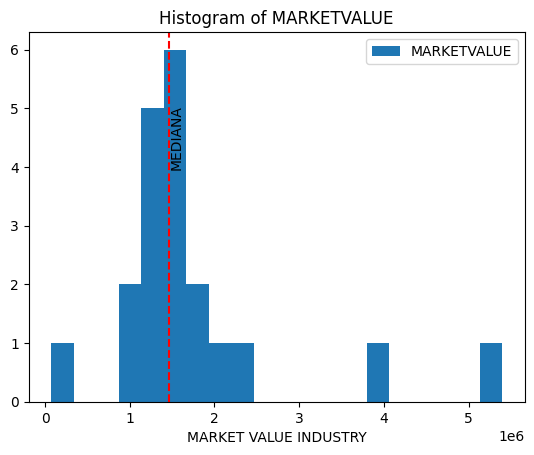

In [23]:
from matplotlib import pyplot

bins = 20

pyplot.hist((M_.values),bins,alpha=1,label='MARKETVALUE')
pyplot.legend(loc='upper right')
pyplot.title(label='Histogram of MARKETVALUE')
pyplot.xlabel('MARKET VALUE INDUSTRY')
pyplot.axvline(x=M_.median(),color='red',linestyle = 'dashed')
pyplot.text(M_.median(),4,'MEDIANA',color='black',rotation=90)
pyplot.show()


En este caso sacamos las mediana sectorial del mercado de EE.UU para visualizar en donde se localizan las mayoria de la industira. Es posible observar que la mediana de todas las industrias es de 1,466,411 dolares. El histograma se distribuye a una tendencia normal. 



In [83]:

# Agrupar el DataFrame 'data' por la columna 'Empresa' y seleccionar las columnas 'BOOKVALUE', 'MARKETVALUE', y 'year'.
# Se aplica una función lambda que simplemente devuelve los datos sin modificaciones.
empresam = data.groupby('Empresa')[['BOOKVALUE', 'MARKETVALUE','fiscalmonth','year']].apply(lambda x: x)

# Filtrar el DataFrame para mantener solo las filas donde el año ('year') sea igual a 2023.
empresam = empresam[(empresam['fiscalmonth'] == 12) & (empresam['year'] == 2023)]

# Imprimir las columnas del DataFrame 'empresam' para verificar que se tienen las columnas correctas.
print(empresam)

# Agrupar el DataFrame filtrado por la columna 'firm' y calcular varias estadísticas (suma, mínimo, máximo,
# desviación estándar, mediana y media) solo para la columna 'MARKETVALUE'.
empresam = empresam.groupby('firm')[['MARKETVALUE']].agg(['sum', 'min', 'max', 'std', 'median', 'mean'])

# Ordenar el DataFrame resultante en orden descendente por la media ('mean') de 'MARKETVALUE'.
empresam = empresam.sort_values(by=('MARKETVALUE', 'mean'), ascending=False)
M = empresam[('MARKETVALUE', 'median')]

print('-----------------------------')
print()
print('Mediana de las empresas EE.UU', M.median())
empresam[0:10]



C:\Users\KOKAS\AppData\Local\Temp\ipykernel_4288\1994878809.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  empresam = data.groupby('Empresa')[['BOOKVALUE', 'MARKETVALUE','fiscalmonth','year']].apply(lambda x: x)


             BOOKVALUE   MARKETVALUE  fiscalmonth  year
firm qdate                                             
A    2023Q4  5845000.0  4.073636e+07         12.0  2023
AA   2023Q4  5845000.0  6.068045e+06         12.0  2023
AAL  2023Q4 -5202000.0  8.979647e+06         12.0  2023
AAME 2023Q4   107275.0  4.998765e+04         12.0  2023
AAOI 2023Q4   214869.0  6.865667e+05         12.0  2023
...                ...           ...          ...   ...
ZTS  2023Q4  4991000.0  9.061527e+07         12.0  2023
ZUMZ 2023Q1   407328.0  3.593879e+05         12.0  2023
ZUO  2023Q1    97160.0  1.338740e+06         12.0  2023
ZVIA 2023Q4    61767.0  1.433941e+05         12.0  2023
ZWS  2023Q4  1602800.0  5.082358e+06         12.0  2023

[3429 rows x 4 columns]
-----------------------------

Mediana de las empresas EE.UU 1245276.1203599998


MARKETVALUE                                                \
                sum           min           max std        median   
firm                                                                
AAPL   2.676737e+09  2.676737e+09  2.676737e+09 NaN  2.676737e+09   
MSFT   2.532081e+09  2.532081e+09  2.532081e+09 NaN  2.532081e+09   
GOOGL  1.748360e+09  1.748360e+09  1.748360e+09 NaN  1.748360e+09   
AMZN   1.570153e+09  1.570153e+09  1.570153e+09 NaN  1.570153e+09   
META   9.096286e+08  9.096286e+08  9.096286e+08 NaN  9.096286e+08   
TSLA   7.898984e+08  7.898984e+08  7.898984e+08 NaN  7.898984e+08   
NVDA   6.860919e+08  6.860919e+08  6.860919e+08 NaN  6.860919e+08   
LLY    5.533702e+08  5.533702e+08  5.533702e+08 NaN  5.533702e+08   
AVGO   5.225619e+08  5.225619e+08  5.225619e+08 NaN  5.225619e+08   
JPM    4.917605e+08  4.917605e+08  4.917605e+08 NaN  4.917605e+08   

                     
               mean  
firm                 
AAPL   2.676737e+09  
MSFT   2.532081e+09  
GOOGL  1.748360e+09  
AMZN   1.570153e+09  
META   9.096286e+08  
TSLA   7.898984e+08  
NVDA   6.860919e+08  
LLY    5.533702e+08  
AVGO   5.225619e+08  
JPM    4.917605e+08

En las métricas pasadas, agrupamos las top 10 empresas del mercado estadounidense con respecto a su promedio de su valor en el mercado en año fiscal más reciente.
Además calculamos la distribución de la mayoria de las empresas con respecto a su valor del mercado, para ello calculamos la median de las empresas en su año fiscal del 2023, es de 1,245,276 dolares. 

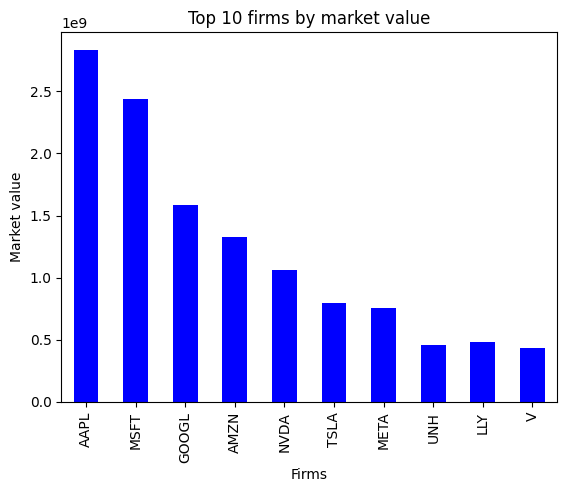

In [25]:
M[0:10].plot(kind='bar', color='blue')
plt.title('Top 10 firms by market value')
plt.ylabel('Market value')
plt.xlabel('Firms')
plt.show()

El gráfico muestra las top 10 empresas con mayor valor en el mercado  en su año fiscal del 2023. La mayoria de las empresas cuentan con un valor en el mercado de 1,245,276 dolares, mientras que las top 10 van de 500,000,000 a 2,500,000,000 de dolares, una empresa en promedio es 400 veces más chica con respecto a la empresa ubicada en el décimo lugar del top 10. 

In [84]:
# Agrupar el DataFrame 'data' por la columna 'Empresa' y seleccionar las columnas 'BOOKVALUE', 'MARKETVALUE', y 'fiscalmonth'.
# Se aplica una función lambda que simplemente devuelve los datos sin modificaciones.
empresab = data.groupby('Empresa')[['BOOKVALUE', 'MARKETVALUE','fiscalmonth','year']].apply(lambda x: x)

# Filtrar el DataFrame para mantener solo las filas donde el año ('year') sea igual a 2023.
empresab = empresab[(empresab['fiscalmonth'] == 12) & (empresab['year'] == 2023)]

# Imprimir las columnas del DataFrame 'empresab' para verificar que se tienen las columnas correctas.
print(empresab.columns)

# Agrupar el DataFrame filtrado por la columna 'firm' y calcular varias estadísticas (suma, mínimo, máximo,
# desviación estándar, mediana y media) solo para la columna 'BOOKVALUE'.
empresab = empresab.groupby('firm')[['BOOKVALUE']].agg(['sum', 'min', 'max', 'std', 'median', 'mean'])

# Ordenar el DataFrame resultante en orden descendente por la media ('mean') de 'MARKETVALUE'.
empresab = empresab.sort_values(by=('BOOKVALUE', 'mean'), ascending=False)
B = empresab[('BOOKVALUE', 'median')]
print('-----------------------------')
print()
print('Mediana de las empresas EE.UU', B.median())
# Mostrar las top 10 empresas.
empresab[0:10]

C:\Users\KOKAS\AppData\Local\Temp\ipykernel_4288\1657676998.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  empresab = data.groupby('Empresa')[['BOOKVALUE', 'MARKETVALUE','fiscalmonth','year']].apply(lambda x: x)


Index(['BOOKVALUE', 'MARKETVALUE', 'fiscalmonth', 'year'], dtype='object')
-----------------------------

Mediana de las empresas EE.UU 498273.5


BOOKVALUE                                                        
               sum          min          max std       median         mean
firm                                                                      
BRK_B  561273000.0  561273000.0  561273000.0 NaN  561273000.0  561273000.0
JPM    327878000.0  327878000.0  327878000.0 NaN  327878000.0  327878000.0
BAC    291646000.0  291646000.0  291646000.0 NaN  291646000.0  291646000.0
GOOGL  283379000.0  283379000.0  283379000.0 NaN  283379000.0  283379000.0
XOM    212538000.0  212538000.0  212538000.0 NaN  212538000.0  212538000.0
C      206251000.0  206251000.0  206251000.0 NaN  206251000.0  206251000.0
MSFT   206223000.0  206223000.0  206223000.0 NaN  206223000.0  206223000.0
AMZN   201875000.0  201875000.0  201875000.0 NaN  201875000.0  201875000.0
WFC    187443000.0  187443000.0  187443000.0 NaN  187443000.0  187443000.0
CVX    161929000.0  161929000.0  161929000.0 NaN  161929000.0  161929000.0

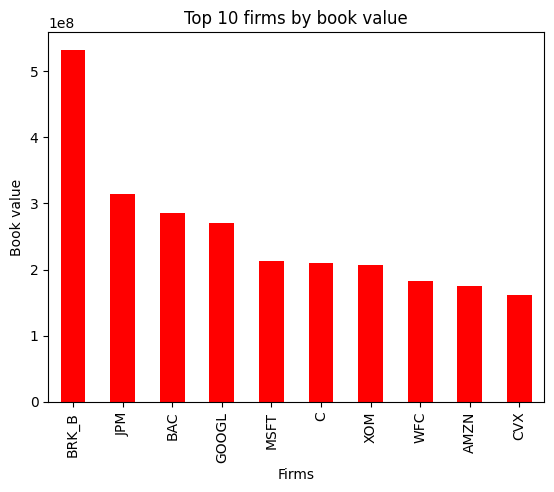

In [27]:
B[0:10].plot(kind='bar', color='red')
plt.title('Top 10 firms by book value')
plt.ylabel('Book value')
plt.xlabel('Firms')
plt.show()

El gráfico muestra las top 10 empresas con mayor valor neto de su año fiscal del 2023. La mayoria de las empresas cuentan con un valor neto de 498,273 dolares al cierre de us año fiscal, mientras que las top 10 van de 190,000,000 a 500,000,000 de dolares, una empresa en promedio es 381 veces más chica con respecto a la empresa ubicada en la décimo lugar del top 10. 

<hr>

# EVOLUCIÓN DEL MERCADO FINANCIERO ESTADOUNIDENSE
A que  conciderar todo el historial financiero de todas las empresas de la dataset, es importante del cierre fiscal para tomar todo el valor del año. 

In [28]:
month12_data = data[data['fiscalmonth'] == 12]
month12_data

q  fiscalmonth     revenue       cogs         sgae  \
firm     qdate                                                             
A        2000Q4  2000q4         12.0  10773000.0  5522000.0  4198000.000   
         2001Q4  2001q4         12.0   8396000.0  5166000.0  4008000.000   
         2002Q4  2002q4         12.0   6010000.0  3694000.0  3923000.000   
         2003Q4  2003q4         12.0   6056000.0  3762000.0  3019000.000   
         2004Q4  2004q4         12.0   7181000.0  4058000.0  2737000.000   
...                 ...          ...         ...        ...          ...   
ZYNE_old 2019Q4  2019q4         12.0         NaN        0.0    34319.810   
         2020Q4  2020q4         12.0         NaN        0.0    52062.542   
         2021Q4  2021q4         12.0         NaN        0.0    36770.390   
         2022Q4  2022q4         12.0         NaN        0.0    35251.540   
ZY_old   2021Q4  2021q4         12.0     16743.0    69721.0   294585.000   

                 otherincome  extraordinaryitems     finexp  incometax  \
firm     qdate                                                           
A        2000Q4   111000.000        0.000000e+00      0.000   407000.0   
         2001Q4   301000.000        5.800000e+05      0.000   -71000.0   
         2002Q4    60000.000       -1.000000e+04      0.000  -525000.0   
         2003Q4    35000.000       -2.680000e+05      0.000  1100000.0   
         2004Q4    54000.000        0.000000e+00      0.000    91000.0   
...                      ...                 ...        ...        ...   
ZYNE_old 2019Q4     -145.911        0.000000e+00  -1522.138        0.0   
         2020Q4      481.719        0.000000e+00   -243.992        0.0   
         2021Q4     -559.681        0.000000e+00    -21.047        0.0   
         2022Q4     -631.126        7.275958e-12   -846.860        0.0   
ZY_old   2021Q4      470.000        0.000000e+00  14641.000       51.0   

                 totalassets  ...   MARKETVALUE  BOOKMARKET  cc_return_q  \
firm     qdate                ...                                          
A        2000Q4  8425000.000  ...  2.498606e+07    0.210718     0.112233   
         2001Q4  7986000.000  ...  1.321995e+07    0.428065     0.377280   
         2002Q4  8203000.000  ...  8.387759e+06    0.551637     0.318593   
         2003Q4  6297000.000  ...  1.392260e+07    0.202836     0.279508   
         2004Q4  7056000.000  ...  1.173287e+07    0.304188     0.110908   
...                      ...  ...           ...         ...          ...   
ZYNE_old 2019Q4    87764.596  ...  1.401160e+05    0.539530    -0.224467   
         2020Q4    74056.776  ...  9.714928e+04    0.619084    -0.003026   
         2021Q4    81171.507  ...  1.187065e+05    0.597384    -0.386773   
         2022Q4    55520.894  ...  2.494324e+04    1.853358    -0.322904   
ZY_old   2021Q4   522396.000  ...  6.850613e+05    0.596277    -0.677328   

                 cc_return_y  cc_return_q_f  cc_return_y_f  Gross Margin  \
firm     qdate                                                             
A        2000Q4          NaN      -0.577538      -0.652522      0.487422   
         2001Q4    -0.652522       0.203950      -0.462108      0.384707   
         2002Q4    -0.462108      -0.311725       0.487391      0.385358   
         2003Q4     0.487391       0.078568      -0.193326      0.378798   
         2004Q4    -0.193326      -0.082120       0.323045      0.434898   
...                      ...            ...            ...           ...   
ZYNE_old 2019Q4     0.709842      -0.455539      -0.604482           NaN   
         2020Q4    -0.604482       0.342945      -0.136132           NaN   
         2021Q4    -0.136132      -0.339951      -1.692669           NaN   
         2022Q4    -1.692669      -0.209092       0.897243           NaN   
ZY_old   2021Q4          NaN      -0.839357      -1.012723     -3.164188   

                 Net Profit Margin       ROE         P/E  
firm     qdate                   

In [29]:
MARKETVALUE_total = month12_data.groupby('year').agg({
    'MARKETVALUE': 'sum'
}).reset_index()
MARKETVALUE_total =MARKETVALUE_total.iloc[:-1]
print('MARKETVALUE_total')
print(MARKETVALUE_total)


MARKETVALUE_total
    year   MARKETVALUE
0   2000  1.271442e+10
1   2001  1.138682e+10
2   2002  9.382138e+09
3   2003  1.155087e+10
4   2004  1.310071e+10
5   2005  1.365024e+10
6   2006  1.529529e+10
7   2007  1.593777e+10
8   2008  1.024751e+10
9   2009  1.163598e+10
10  2010  1.355240e+10
11  2011  1.642614e+10
12  2012  1.638882e+10
13  2013  2.088287e+10
14  2014  2.314045e+10
15  2015  2.301566e+10
16  2016  2.441035e+10
17  2017  2.807695e+10
18  2018  2.680193e+10
19  2019  3.215222e+10
20  2020  3.807889e+10
21  2021  4.865966e+10
22  2022  3.983687e+10
23  2023  4.605377e+10


Agrupamos por año el total del valor del mercado, con el fin de estimar el crecimiento de esta variable. 

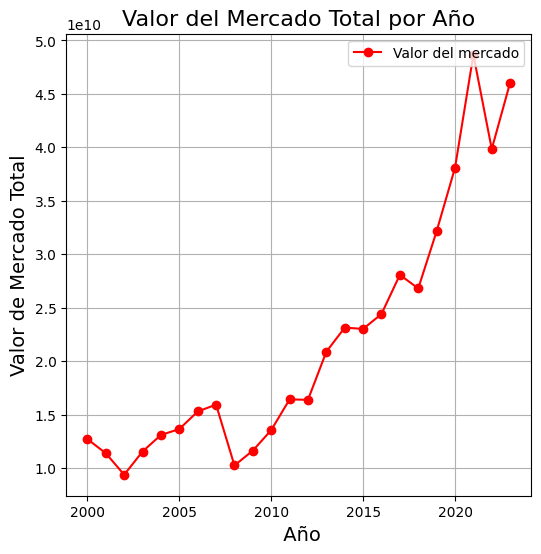

In [30]:
plt.figure(figsize=(6, 6))  # Aumentar el tamaño de la figura para mayor claridad
plt.plot(MARKETVALUE_total['year'],MARKETVALUE_total['MARKETVALUE'],'r-o')


# Títulos y etiquetas
plt.title('Valor del Mercado Total por Año', fontsize=16)
plt.xlabel(' Año', fontsize=14)
plt.ylabel('Valor de Mercado Total', fontsize=14)

# Añadir leyenda
plt.legend(['Valor del mercado'], loc='upper right')

plt.grid(True)
plt.show()


Gráficamente prodemos visualizar que el valor del mercado a ido aumentando hasta el 2021, depués de este año redujo su valor del mercado, perdio valor, esto se puede deber a la guerra de ucrania y la secuelas de la pandemia. De otro modo, el mercado de EE.UU tiene la tendencia de estar constantemente creciendo, ya que en su mercado están las empresas más grandes del mundo, el mercado están sólido que la pandemia y otros hecho mundiales no han efectado drásticamente a su crecimiento de este mercado. 

In [31]:
revenue_income = month12_data.groupby('year').agg({
    'revenue': 'sum',
    'NETINCOME': 'sum'
}).reset_index()
revenue_income= revenue_income.iloc[:-1]
print('revenue_total y NETINCOME_total')
print(revenue_income )



revenue_total y NETINCOME_total
    year       revenue     NETINCOME
0   2000  6.656273e+09  2.039280e+09
1   2001  7.758654e+09  2.211922e+09
2   2002  7.575908e+09  2.053121e+09
3   2003  8.213610e+09  2.513545e+09
4   2004  9.097849e+09  2.776006e+09
5   2005  9.971419e+09  3.004158e+09
6   2006  1.093114e+10  3.311058e+09
7   2007  1.159291e+10  3.466942e+09
8   2008  1.175305e+10  3.707809e+09
9   2009  1.075167e+10  3.491238e+09
10  2010  1.168569e+10  3.629246e+09
11  2011  1.354407e+10  4.293439e+09
12  2012  1.405378e+10  4.325207e+09
13  2013  1.441442e+10  4.477514e+09
14  2014  1.493200e+10  4.687332e+09
15  2015  1.445078e+10  4.681814e+09
16  2016  1.437061e+10  4.594936e+09
17  2017  1.522750e+10  4.925549e+09
18  2018  1.616276e+10  5.263107e+09
19  2019  1.676664e+10  5.397186e+09
20  2020  1.602479e+10  5.166797e+09
21  2021  1.860827e+10  6.254113e+09
22  2022  2.107170e+10  6.802028e+09
23  2023  2.164872e+10  6.920997e+09


NUevamente agrupamos la suma total por año de Ingresos(Revenue) e Ingresos netos(Net Income), para poder graficar como se ha comportado estas dos variables a lo largo del 2000 al 2023.


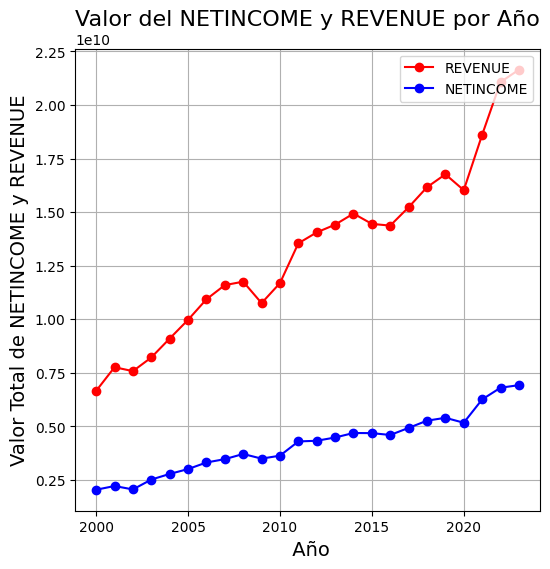

In [32]:
plt.figure(figsize=(6, 6))  # Aumentar el tamaño de la figura para mayor claridad
plt.plot(revenue_income ['year'],revenue_income['revenue'],'r-o')
plt.plot(revenue_income ['year'],revenue_income['NETINCOME'],'b-o')

# Títulos y etiquetas
plt.title('Valor del NETINCOME y REVENUE por Año', fontsize=16)
plt.xlabel(' Año', fontsize=14)
plt.ylabel('Valor Total de NETINCOME y REVENUE', fontsize=14)

# Añadir leyenda
plt.legend(['REVENUE', 'NETINCOME'], loc='upper right')

plt.grid(True)
plt.show()



En revenue o ganancias, el mercado a solo acumulado, no ha perdido, que prácticamente las empresas han aumentado su capacidad de la empresa para generar dinero a través de sus operaciones principales. 

En net-income o ingreso neto, nuevamente el mercado ha aumentado, esto quiere decir que realmente las empresas del mercado de EE.UU  son rentables, ya que no presentan perdidas significativas y pueden solventar todos sus costos y obligaciones ante cualquier incertidumbre global debido a su pronta recuperación del covid y de las guerras del medio oriente. 


<hr>

# EVALUANDO LA INDUSTRIA 
Evaluaremos la industria del comercio al por mayor y menor. 

In [33]:
data_commercial = data[(data['industria'] == 'Comercio al por mayor') | (data['industria'] == 'Comercio al por menor')]
data_commercial= data_commercial.iloc[:-2]
data_commercial

q  fiscalmonth  revenue  cogs  sgae  otherincome  \
firm   qdate                                                           
AAP    2000Q1  2000q1          NaN      NaN   NaN   NaN          NaN   
       2000Q2  2000q2          NaN      NaN   NaN   NaN          NaN   
       2000Q3  2000q3          NaN      NaN   NaN   NaN          NaN   
       2000Q4  2000q4          NaN      NaN   NaN   NaN          NaN   
       2001Q1  2001q1          NaN      NaN   NaN   NaN          NaN   
...               ...          ...      ...   ...   ...          ...   
ZU_old 2022Q4  2022q4          NaN      NaN   NaN   NaN          NaN   
       2023Q1  2023q1          NaN      NaN   NaN   NaN          NaN   
       2023Q2  2023q2          NaN      NaN   NaN   NaN          NaN   
       2023Q3  2023q3          NaN      NaN   NaN   NaN          NaN   
       2023Q4  2023q4          NaN      NaN   NaN   NaN          NaN   

               extraordinaryitems  finexp  incometax  totalassets  ...  \
firm   qdate                                                       ...   
AAP    2000Q1                 NaN     NaN        NaN          NaN  ...   
       2000Q2                 NaN     NaN        NaN          NaN  ...   
       2000Q3                 NaN     NaN        NaN          NaN  ...   
       2000Q4                 NaN     NaN        NaN          NaN  ...   
       2001Q1                 NaN     NaN        NaN          NaN  ...   
...                           ...     ...        ...          ...  ...   
ZU_old 2022Q4                 NaN     NaN        NaN          NaN  ...   
       2023Q1                 NaN     NaN        NaN          NaN  ...   
       2023Q2                 NaN     NaN        NaN          NaN  ...   
       2023Q3                 NaN     NaN        NaN          NaN  ...   
       2023Q4                 NaN     NaN        NaN          NaN  ...   

               MARKETVALUE  BOOKMARKET  cc_return_q  cc_return_y  \
firm   qdate                                                       
AAP    2000Q1          NaN         NaN          NaN          NaN   
       2000Q2          NaN         NaN          NaN          NaN   
       2000Q3          NaN         NaN          NaN          NaN   
       2000Q4          NaN         NaN          NaN          NaN   
       2001Q1          NaN         NaN          NaN          NaN   
...                    ...         ...          ...          ...   
ZU_old 2022Q4          NaN         NaN          NaN          NaN   
       2023Q1          NaN         NaN          NaN          NaN   
       2023Q2          NaN         NaN          NaN          NaN   
       2023Q3          NaN         NaN          NaN          NaN   
       2023Q4          NaN         NaN          NaN          NaN   

               cc_return_q_f  cc_return_y_f  Gross Margin  Net Profit Margin  \
firm   qdate                                                                   
AAP    2000Q1            NaN            NaN           NaN                NaN   
       2000Q2            NaN            NaN           NaN                NaN   
       2000Q3            NaN            NaN           NaN                NaN   
       2000Q4            NaN            NaN           NaN                NaN   
       2001Q1            NaN            NaN           NaN                NaN   
...                      ...            ...           ...                ...   
ZU_old 2022Q4            NaN            NaN           NaN                NaN   
       2023Q1            NaN            NaN           NaN                NaN   
       2023Q2            NaN            NaN           NaN                NaN   
       2023Q3            NaN            NaN           NaN                NaN   
       2023Q4            NaN            NaN           NaN                NaN   

               ROE  P/E  
firm   qdate             
AAP    2000Q1  NaN  NaN  
       2000Q2  NaN  NaN  
       2000Q3  NaN  NaN  
       2000Q4  NaN  NaN  
       2001Q1  NaN  NaN  
...         

Seccionamos nuestra dataset con todas aquellas empresas que pertenezcan al sector de ventas minoristas y mayoristas.

> **Advertencia**: VAMOS ELIMINAR TODAS AQUELLAS EMPRESAS QUE DEL 2000 AL 2023 NO HAYAN TENIDO PRESENCIA FISCAL DENTRO DE ESTE RANGO, Y OTROS INDICADORES.

In [34]:
print(f"Companies in commercial: {data_commercial.shape[0]},\n {data_commercial.isna().sum()}")

Companies in commercial: 35723,
 q                         0
fiscalmonth           16871
revenue               16902
cogs                  16871
sgae                  16871
otherincome           16871
extraordinaryitems    16871
finexp                16871
incometax             16871
totalassets           16871
currentassets         16871
inventory             16871
totalliabilities      16871
currentliabilities    16871
longdebt              16871
adjprice              16899
originalprice         16899
sharesoutstanding     12264
year                      0
fixedassets           16871
yearf                 16871
cto                       0
fiscalq               16871
Empresa                   0
status                    0
industria                 0
GROSSPROFIT           16871
EBIT                  16871
NETINCOME             16875
EBT                   16871
EPS                   17036
EPSP                  17614
BOOKVALUE             16871
MARKETVALUE           17228
BOOKMARKET     

Observamos que tenemos 18852 Nan en nuestra dataset, y muchas de ellas son de empresas que aún habían nacido antes del 2015 u otro año. 

In [35]:
print(f"Companies in commercial: {data_commercial.shape[0]},\n {data_commercial.isna().sum()}")

# Filtra las filas con más de un valor NaN y que también tienen NaN en 'fiscalmonth'
rows_to_drop = data_commercial[data_commercial['fiscalmonth'].isna() & (data_commercial.isna().sum(axis=1) > 1)].index

# Elimina las filas identificadas
data_commercial = data_commercial.drop(rows_to_drop)

# Imprime la cantidad de NaN restantes en la columna 'fiscalmonth'
print(data_commercial['fiscalmonth'].isna().sum())


Companies in commercial: 35723,
 q                         0
fiscalmonth           16871
revenue               16902
cogs                  16871
sgae                  16871
otherincome           16871
extraordinaryitems    16871
finexp                16871
incometax             16871
totalassets           16871
currentassets         16871
inventory             16871
totalliabilities      16871
currentliabilities    16871
longdebt              16871
adjprice              16899
originalprice         16899
sharesoutstanding     12264
year                      0
fixedassets           16871
yearf                 16871
cto                       0
fiscalq               16871
Empresa                   0
status                    0
industria                 0
GROSSPROFIT           16871
EBIT                  16871
NETINCOME             16875
EBT                   16871
EPS                   17036
EPSP                  17614
BOOKVALUE             16871
MARKETVALUE           17228
BOOKMARKET     

Para resolver esta situación optamos por eliminar aquellas empresas que su fiscalmonth es NAN y dentro de sus renglones tengas más de 2 NAN, aparte del fiscalmonth.

In [36]:
data_commercial

q  fiscalmonth    revenue       cogs       sgae  \
firm   qdate                                                          
AAP    2001Q4  2001q4         12.0  2517639.0  1441613.0   977814.0   
       2002Q2  2002q2          4.0  1004087.0   567579.0   388154.0   
       2002Q3  2002q3          9.0  2585466.0  1450282.0   967035.0   
       2002Q4  2002q4         12.0  3287883.0  1839889.0  1246009.0   
       2003Q2  2003q2          4.0  1033537.0   565728.0   393276.0   
...               ...          ...        ...        ...        ...   
ZU_old 2014Q2  2014q2          6.0   522894.0   378203.0   139966.0   
       2014Q3  2014q3          9.0   808730.0   585350.0   219318.0   
       2014Q4  2014q4         12.0  1200079.0   875633.0   308716.0   
       2015Q1  2015q1          3.0   306616.0   214390.0    96679.0   
       2015Q2  2015q2          6.0   604177.0   419462.0   183883.0   

               otherincome  extraordinaryitems   finexp  incometax  \
firm   qdate                                                         
AAP    2001Q4      -7816.0             -5747.0  61895.0    11312.0   
       2002Q2        273.0              -775.0  27598.0     8158.0   
       2002Q3        949.0             -8694.0  62734.0    41270.0   
       2002Q4       -575.0            -10373.0  78219.0    47799.0   
       2003Q2     -46769.0                 0.0  19567.0     3156.0   
...                    ...                 ...      ...        ...   
ZU_old 2014Q2        -64.0                 0.0   -145.0        0.0   
       2014Q3         12.0                 0.0   -237.0      300.0   
       2014Q4        -46.0                 0.0   -317.0     1109.0   
       2015Q1        -63.0                 0.0   -170.0    -1860.0   
       2015Q2        -55.0                 0.0   -332.0       55.0   

               totalassets  ...   MARKETVALUE  BOOKMARKET  cc_return_q  \
firm   qdate                ...                                          
AAP    2001Q4    1950615.0  ...           NaN         NaN          NaN   
       2002Q2    2049204.0  ...  1.910804e+06    0.204883     0.169743   
       2002Q3    2083203.0  ...  1.880993e+06    0.242527    -0.033010   
       2002Q4    1965225.0  ...  1.745366e+06    0.268343    -0.075597   
       2003Q2    1989851.0  ...  2.212697e+06    0.219707     0.275172   
...                    ...  ...           ...         ...          ...   
ZU_old 2014Q2     403329.0  ...  5.084192e+06    0.050230    -0.203464   
       2014Q3     465943.0  ...  4.731956e+06    0.055065    -0.077665   
       2014Q4     492378.0  ...  2.932871e+06    0.094093    -0.481951   
       2015Q1     448031.0  ...  1.623625e+06    0.152697    -0.588556   
       2015Q2     448476.0  ...  1.610121e+06    0.160557     0.003842   

               cc_return_y  cc_return_q_f  cc_return_y_f  Gross Margin  \
firm   qdate                                                             
AAP    2001Q4          NaN      -0.078369      -0.017233      0.427395   
       2002Q2          NaN      -0.033010       0.110849      0.434731   
       2002Q3          NaN      -0.075597       0.295896      0.439064   
       2002Q4    -0.017233      -0.055716       0.509598      0.440403   
       2003Q2     0.110849       0.152037       0.372186      0.452629   
...                    ...            ...            ...           ...   
ZU_old 2014Q2          NaN      -0.077665      -1.144330      0.276712   
       2014Q3          NaN      -0.481951      -0.778217      0.276211   
       2014Q4    -0.571269      -0.588556            NaN      0.270354   
       2015Q1    -1.351636       0.003842            NaN      0.300787   
       2015Q2    -1.144330       0.288449            NaN      0.305730   

               Net Profit Margin       ROE        P/E  
firm   qdate                                           
AAP    2001Q4           0.392930  3.428120        NaN  
       2002Q2           0.398621  1.022371   4.774026  
       2002Q3           0.395842  2

##  Estadísticas descriptivas para nuestra industria


In [37]:
data_filtrada = data_commercial[
    (data_commercial['fiscalmonth'] == 12) &
    (data_commercial['year'] == 2023)
]
data_filtrada 

,,q,fiscalmonth,revenue,cogs,sgae,otherincome,extraordinaryitems,finexp,incometax,totalassets,...,MARKETVALUE,BOOKMARKET,cc_return_q,cc_return_y,cc_return_q_f,cc_return_y_f,Gross Margin,Net Profit Margin,ROE,P/E
firm,qdate,,,,,,,,,,,,,,,,,,,,,
AAP,2023Q4,2023q4,12.0,11287607.0,6764105.0,4409125.0,5525.0,0.0,88055.0,2112.0,12276326.0,...,3.631406e+06,0.693871,0.092154,-0.858403,0.336452,NaN,0.400749,0.393251,1.761643,0.818094
ABG,2023Q4,2023q4,12.0,14802700.0,12046900.0,1802300.0,13500.0,0.0,165700.0,198800.0,10159400.0,...,4.629291e+06,0.700798,-0.022417,0.227186,0.046932,NaN,0.186169,0.162457,0.741261,1.925021
ACI,2023Q1,2023q1,12.0,77649700.0,55894100.0,19448500.0,33000.0,0.0,404600.0,422000.0,26168200.0,...,1.113221e+07,0.144688,0.007603,-0.163737,0.054619,0.053557,0.280176,0.269956,13.014217,0.531066
AE,2023Q4,2023q4,12.0,2745293.0,0.0,2742894.0,0.0,0.0,1913.0,274.0,361334.0,...,6.666583e+04,1.390758,-0.243600,-0.370335,0.111313,NaN,1.000000,0.999203,29.586112,0.024303
AEO,2023Q1,2023q1,12.0,4989833.0,3244585.0,1498201.0,-54256.0,0.0,14297.0,53358.0,3420956.0,...,2.628274e+06,0.608446,-0.037961,-0.207518,-0.122804,0.679437,0.349761,0.325329,1.015117,1.619056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WOOF,2023Q1,2023q1,12.0,6035967.0,3608860.0,2201548.0,-12667.0,13867.0,100611.0,35347.0,6612829.0,...,2.060672e+06,1.155680,-0.051960,-0.776773,-0.011173,-1.373049,0.402107,0.379782,0.962574,0.898935
WSM,2023Q1,2023q1,12.0,8674417.0,4996684.0,2179311.0,0.0,0.0,-2260.0,372778.0,4663016.0,...,8.057328e+06,0.211119,0.063284,-0.151329,0.035590,0.983636,0.423975,0.381261,1.944219,2.436288
WSO,2023Q4,2023q4,12.0,7283767.0,5291627.0,1197330.0,0.0,-97802.0,4920.0,155751.0,3729182.0,...,1.687924e+07,0.154995,0.132491,0.570992,0.014163,NaN,0.273504,0.238018,0.662669,9.736151


Ahora bien, vamos a interpretar como es la industria actualmente, para ello vamos a seccionar nuestra dataset con todas las empresas que tuvieron registro en el año 2023. 

### Estadística descriptiva para el sector mayorista y minorista

In [38]:
columns = [
    'cc_return_y_f',
    'totalassets',
    'revenue',
    'NETINCOME',
    'BOOKVALUE',
    'MARKETVALUE',
    'ROE',
    'P/E',
    'Net Profit Margin',
    'Gross Margin',
    'BOOKMARKET',
    'EPSP'
]

data_filtrada2 = data_filtrada[columns].copy()
data_filtrada2.describe()

,cc_return_y_f,totalassets,revenue,NETINCOME,BOOKVALUE,MARKETVALUE,ROE,P/E,Net Profit Margin,Gross Margin,BOOKMARKET,EPSP
count,84.000000,2.200000e+02,2.190000e+02,2.200000e+02,2.200000e+02,2.140000e+02,220.000000,214.000000,219.000000,219.000000,214.000000,214.000000
mean,-0.096497,1.152665e+07,2.219573e+07,4.604014e+06,3.043958e+06,1.967454e+07,1.384584,2.512729,0.293762,0.323162,0.337130,1.371773
std,0.739882,4.380075e+07,7.118231e+07,2.059272e+07,1.577559e+07,1.139984e+08,4.421958,5.929026,0.194705,0.177045,3.957272,4.093901
min,-2.979984,5.717332e+03,6.108000e+03,-7.981911e+03,-1.425400e+07,2.805199e+03,-21.350305,-61.601277,-0.964906,-0.154714,-55.840026,-1.231650
25%,-0.291181,5.811862e+05,9.199220e+05,2.830792e+05,1.406795e+05,3.012000e+05,0.544150,0.824905,0.190513,0.206559,0.192065,0.261283
50%,0.094629,2.388440e+06,3.315428e+06,9.117435e+05,5.509170e+05,1.476284e+06,1.021063,1.926960,0.288224,0.304884,0.470522,0.501173
75%,0.301504,7.296023e+06,1.235360e+07,2.838229e+06,1.900560e+06,7.939630e+06,1.862255,3.699917,0.371155,0.394681,0.827985,1.116045
max,1.507714,5.278540e+08,6.112890e+08,2.636190e+08,2.018750e+08,1.570153e+09,29.586112,27.720387,0.999203,1.000000,6.921855,41.147109


In [39]:
data_filtrada['revenue'].describe()

count    2.190000e+02
mean     2.219573e+07
std      7.118231e+07
min      6.108000e+03
25%      9.199220e+05
50%      3.315428e+06
75%      1.235360e+07
max      6.112890e+08
Name: revenue, dtype: float64

El ingreso de una empresa de estadounidense registra en promedio 22,100,000 dolares en el 2023. El mayor ingreso registrado de este año fue de 611,000,000 dolares, mientras que el mínimo fue de 6,108 dolares, una diferencia de 610,993,892 de dolares, mostrandonos que en el sector mayorista existe una disparidad entre empresas. 

In [40]:
data_filtrada['P/E'].describe()

count    214.000000
mean       2.512729
std        5.929026
min      -61.601277
25%        0.824905
50%        1.926960
75%        3.699917
max       27.720387
Name: P/E, dtype: float64

En este caso vamos evaular el ration Price to Earning, o mejor conocido como relación precio y beneficio. 
Esta variable cuenta con 214 datos de 220 iteraciones, además en promedio las empresas registrarón 2.51, que significa que los inversores pagan 2.51 veces las ganancias por acción adquirida, por otro lado, el mínimo que registró una empresa fue de -61.6, esto quiere decir que esta empresa tuvo perdidas, y el máximo fue de 27, que por cada unidad de la acción pagaban 27 veces más. 

In [41]:
# Eliminar filas con valores faltantes en las variables de interés
data_filtrada_limpia = data_filtrada.dropna(subset=['ROE', 'P/E', 'Net Profit Margin', 'Gross Margin', 'BOOKMARKET', 'EPSP'])

# Variables independientes
variables_independientes = ['ROE', 'P/E', 'Net Profit Margin', 'Gross Margin', 'BOOKMARKET', 'EPSP']

# Calcular la media y mediana de cada variable independiente
medias = data_filtrada_limpia[variables_independientes].mean()
medianas = data_filtrada_limpia[variables_independientes].median()

# Calcular el promedio ponderado de cada variable en función de su media
promedios_ponderados_media = {}
for var in variables_independientes:
    valores = data_filtrada_limpia[var].values
    media = medias[var]
    promedio_ponderado = np.sum(valores * media) / np.sum(valores)
    promedios_ponderados_media[var] = promedio_ponderado

# Calcular el promedio ponderado de cada variable en función de su mediana
promedios_ponderados_mediana = {}
for var in variables_independientes:
    valores = data_filtrada_limpia[var].values
    mediana = medianas[var]
    promedio_ponderado = np.sum(valores * mediana) / np.sum(valores)
    promedios_ponderados_mediana[var] = promedio_ponderado

# Mostrar resultados
print("Promedios Ponderados con respecto a la Media:")
for var, promedio in promedios_ponderados_media.items():
    print(f"{var}: {promedio}")

print("\nPromedios Ponderados con respecto a la Mediana:")
for var, promedio in promedios_ponderados_mediana.items():
    print(f"{var}: {promedio}")

Promedios Ponderados con respecto a la Media:
ROE: 1.329937586612557
P/E: 2.512729069537685
Net Profit Margin: 0.29298269294450624
Gross Margin: 0.32272731805190974
BOOKMARKET: 0.33712968662053894
EPSP: 1.371773437252042

Promedios Ponderados con respecto a la Mediana:
ROE: 1.031768278899363
P/E: 1.926959776249145
Net Profit Margin: 0.2871201273440314
Gross Margin: 0.30329981906552167
BOOKMARKET: 0.47052154222340314
EPSP: 0.5011733514074553


En general, las diferencias entre los promedios ponderados respecto a la media y la mediana pueden indicar la presencia de outliers o una distribución asimétrica de los datos.
Las métricas como ROE y P/E muestran una mayor variación entre la media y la mediana, lo que podría sugerir la influencia de empresas con rendimientos o valoraciones significativamente superiores o inferiores al resto.

<hr>

# MATRÍZ DE CORRELACIÓN


Vamos ocupar los datos fiscales anuales de todos los años, para entender mejor las tendencias o los comportamiento del mercado através de los años.
Además empezaremos a encontrar correlaciones entre variables para contruir nuestro modelo de predicción. 

In [42]:
data_corr = data[
    (data['fiscalmonth'] == 12) & (data['status'] == 'activo')
]
data_corr

q  fiscalmonth     revenue       cogs       sgae  \
firm qdate                                                           
A    2000Q4  2000q4         12.0  10773000.0  5522000.0  4198000.0   
     2001Q4  2001q4         12.0   8396000.0  5166000.0  4008000.0   
     2002Q4  2002q4         12.0   6010000.0  3694000.0  3923000.0   
     2003Q4  2003q4         12.0   6056000.0  3762000.0  3019000.0   
     2004Q4  2004q4         12.0   7181000.0  4058000.0  2737000.0   
...             ...          ...         ...        ...        ...   
ZWS  2019Q1  2019q1         12.0   2050900.0  1266100.0   479200.0   
     2020Q1  2020q1         12.0   2068300.0  1250300.0   483700.0   
     2021Q4  2021q4         12.0    910900.0   537700.0   266200.0   
     2022Q4  2022q4         12.0   1281800.0   816300.0   358400.0   
     2023Q4  2023q4         12.0   1530500.0   882400.0   456700.0   

             otherincome  extraordinaryitems   finexp  incometax  totalassets  \
firm qdate                                                                      
A    2000Q4     111000.0                 0.0      0.0   407000.0    8425000.0   
     2001Q4     301000.0            580000.0      0.0   -71000.0    7986000.0   
     2002Q4      60000.0            -10000.0      0.0  -525000.0    8203000.0   
     2003Q4      35000.0           -268000.0      0.0  1100000.0    6297000.0   
     2004Q4      54000.0                 0.0      0.0    91000.0    7056000.0   
...                  ...                 ...      ...        ...          ...   
ZWS  2019Q1       3100.0           -151100.0  69900.0    53400.0    3259700.0   
     2020Q1     -39400.0             -2100.0  58600.0    54100.0    3627100.0   
     2021Q4     -19900.0             71200.0  34700.0     2700.0    1077700.0   
     2022Q4       3600.0              4700.0  26900.0    26800.0    2864000.0   
     2023Q4      -6100.0              8500.0  38500.0    42600.0    2667000.0   

             ...   MARKETVALUE  BOOKMARKET  cc_return_q  cc_return_y  \
firm qdate   ...                                                       
A    2000Q4  ...  2.498606e+07    0.210718     0.112233          NaN   
     2001Q4  ...  1.321995e+07    0.428065     0.377280    -0.652522   
     2002Q4  ...  8.387759e+06    0.551637     0.318593    -0.462108   
     2003Q4  ...  1.392260e+07    0.202836     0.279508     0.487391   
     2004Q4  ...  1.173287e+07    0.304188     0.110908    -0.193326   
...          ...           ...         ...          ...          ...   
ZWS  2019Q1  ...  2.633934e+06    0.467362     0.091142    -0.166013   
     2020Q1  ...  2.761411e+06    0.475735    -0.361592    -0.101126   
     2021Q4  ...  4.417122e+06    0.028616     0.128964     0.621554   
     2022Q4  ...  3.760356e+06    0.429481    -0.144135    -0.535813   
     2023Q4  ...  5.082358e+06    0.315365     0.051120     0.340976   

             cc_return_q_f  cc_return_y_f  Gross Margin  Net Profit Margin  \
firm qdate                                                                   
A    2000Q4      -0.577538      -0.652522      0.487422           0.459946   
     2001Q4       0.203950      -0.462108      0.384707           0.498094   
     2002Q4      -0.311725       0.487391      0.385358           0.481032   
     2003Q4       0.078568      -0.193326      0.378798           0.158686   
     2004Q4      -0.082120       0.323045      0.434898           0.429745   
...                    ...            ...           ...                ...   
ZWS  2019Q1       0.184044      -0.101126      0.382661           0.250378   
     2020Q1       0.254156       0.740506      0.395494           0.320940   
     2021Q4      -0.026992      -0.535813      0.409705           0.424964   
     2022Q4       0.012859       0.340976      0.363161           0.327742   
     2023Q4       0.131812            NaN      0.423456           0.372035   

                  ROE        P/E  
firm qdate                        
A    2000Q4  0.941121   5.04259

C:\Users\KOKAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\KOKAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\KOKAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


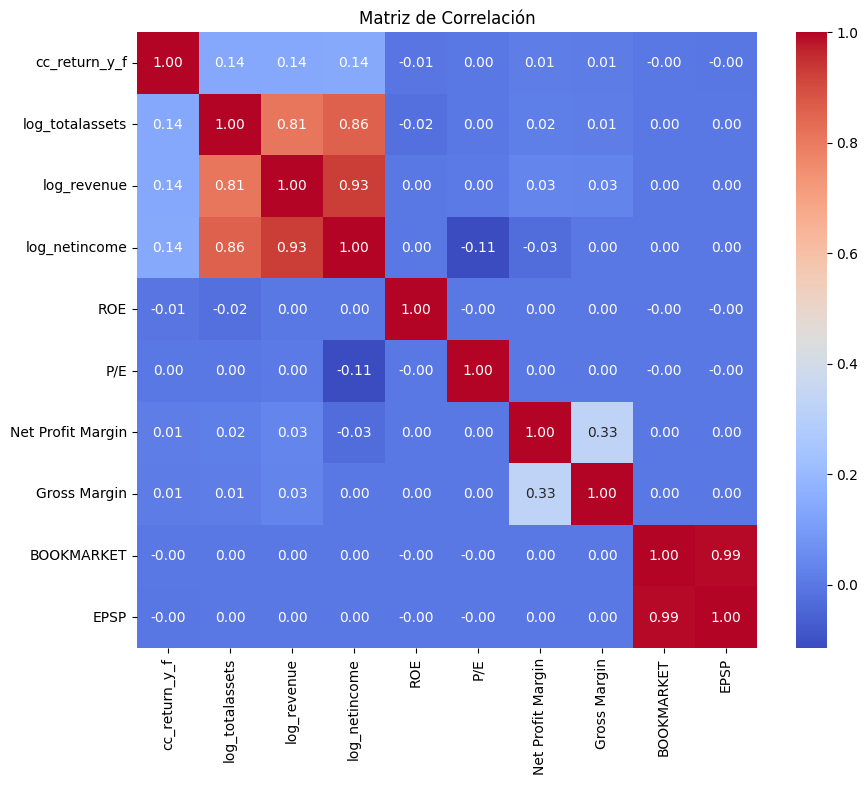

In [43]:


# Supongamos que tus datos están en un DataFrame llamado 'data'
# Columnas: 'totalassets', 'revenue', 'netincome', 'annual_returns', etc.

# 1. Transformación logarítmica de las variables
data ['log_totalassets'] = np.log(data['totalassets'])
data['log_revenue'] = np.log(data['revenue'])
data['log_netincome'] = np.log(data['NETINCOME'])

# 2. Seleccionar las variables que deseas incluir en la matriz de correlación
columns = [
    'cc_return_y_f',
    'log_totalassets',
    'log_revenue',
   'log_netincome',
    'ROE',
    'P/E',
    'Net Profit Margin',
    'Gross Margin',
    'BOOKMARKET',
    'EPSP'
]

corr_matrix = data[columns].corr()

# 3. Mostrar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de Correlación")
plt.show()



Tabla de matríz de correlación entre ratios, variables de control y variable de predicción. 

In [44]:
# 4. Identificar las relaciones más fuertes y significativas con los retornos anuales
target_variable = 'cc_return_y_f'
corr_matrix[target_variable].sort_values(ascending=False)

cc_return_y_f        1.000000
log_netincome        0.144371
log_revenue          0.139718
log_totalassets      0.137854
Net Profit Margin    0.012072
Gross Margin         0.008431
P/E                  0.000920
BOOKMARKET          -0.001186
EPSP                -0.002148
ROE                 -0.006837
Name: cc_return_y_f, dtype: float64

Las tres vairables con mayor correlación positiva son log_netincome, log_revenue y log_totalassets, miesntras las tres variables con mayor correlación negativa son nuestraa dos variables de control Book-market, EPSP y ROE. 

Esto nos ayudará a ver una pre-visualización de las variable que tendrán influencia en nuestro modelo predictivo. 

Correlación positiva

1. Log_netincome, es de  0.144371, nos dice que impacta positivamente cuando retornos anuale tienden a ser mayores 

2. Log_revenue, , es de  0.144371, nos dice que impacta positivamente cuando retornos anuale tienden a ser mayores 

3. Log_totalassets, , es de  0.144371, nos dice que impacta positivamente cuando retornos compuesto anuale tienden a ser mayores 

Correlación negativa

1. Book_market, es de -0.001186, nos dice que impacta inversamente proporcional, nos obtante, al ser tan cercano al cero no influye en los retornos compuestos anuales.  

2. EPSP,es de -0.002148, nos dice que impacta inversamente proporcional, pero al ser tan cercano al cero no influye en los retornos compuestos anuales.

3. ROE, es de 0.000920, nos dice que impacta inversamente proporcional, por lo que al ser tan cercano al cero no influye en los retornos compuestos anuales.

En caso hipotético de que estas tres variables fueran significativas, nos dice que a medida del aumento de esta variables, los retornos compuestos anuales a futuro tenderían a bajar de forma notable.

<hr>

# MODELO DE REGRESIÓN
Una vez previsualizado los datos y tener mayor contexto del mercado de EE.UU, podemos dar pei a la contrucción de nuestro modelo lienal.

Primeramente debemos plantear la estructura, que consiste en conocer las variables dependientes e inpendientes.

<h2>DEPENDIENTE</h2>
Nuestra variable de investigación es aquella que queremos predecir o describir sus tendencias con otras variables, estaremos trabajando con los rendimientos compuestos a futuros años de la acción. En nuestro trabajo se llama 'cc_return_y_f'. 

<h2>INDEPENDIENTE</h2>
Al plantear nuestra variable de investigación, es necesario plantear aquellas variable que describan el comportamiento de la variable independiente. Hemos previsualizado correlaciones entre variables. 

1. Cuatro Ratios
    * ROE (Return on Equity) → Rentabilidad de una empresa
    * Gross Margin → Ingresos después de deducir los gastos
    * Net Profit Margin → Ingresos que se convierten en ingreso neto. 
    * P/E (Price to Earning) → Precio actual de la acción, con sus ganacias por acción
2. Dos Variables de control
    * Book-Market → Es el valor contable de la empresa 
    * EPSP (Earning Price Share Price) → Relación entre la ganacias y su precio de mercado de la empresa

Debemos demostrar que con estas variables independientes que podemos predecir los retorno compuesto a futuro. 

$$ CCreturnYf = (ROE * X_{1}) + 
(GrossMargin*X_{2}) + 
(NetProfitMargin* X_{3}) + 
(P/E*X_{4}) + 
(Book-Market*X_{5}) + 
(EPSP*X_{6}) + 
Const $$




In [45]:
data_regresion = data_commercial[
    (data_commercial['fiscalmonth'] == 12) & (data_commercial['status'] == 'activo')
    
]
data_regresion

q  fiscalmonth    revenue       cogs       sgae  \
firm qdate                                                          
AAP  2001Q4  2001q4         12.0  2517639.0  1441613.0   977814.0   
     2002Q4  2002q4         12.0  3287883.0  1839889.0  1246009.0   
     2003Q4  2003q4         12.0  3493696.0  1889178.0  1316284.0   
     2004Q4  2004q4         12.0  3770297.0  2016926.0  1424613.0   
     2005Q4  2005q4         12.0  4264971.0  2250493.0  1605986.0   
...             ...          ...        ...        ...        ...   
ZUMZ 2020Q1  2020q1         12.0  1034129.0   667566.0   280756.0   
     2021Q1  2021q1         12.0   990652.0   640637.0   253077.0   
     2022Q1  2022q1         12.0  1183867.0   727137.0   298920.0   
     2023Q1  2023q1         12.0   958380.0   633702.0   293578.0   
     2024Q1  2024q1         12.0   875486.0   594596.0   345679.0   

             otherincome  extraordinaryitems   finexp  incometax  totalassets  \
firm qdate                                                                      
AAP  2001Q4      -7816.0             -5747.0  61895.0    11312.0    1950615.0   
     2002Q4       -575.0            -10373.0  78219.0    47799.0    1965225.0   
     2003Q4     -46947.0              -352.0  37576.0    78424.0    1983071.0   
     2004Q4      -2941.0               -39.0  20069.0   117721.0    2201962.0   
     2005Q4       2815.0                 0.0  32384.0   144198.0    2542149.0   
...                  ...                 ...      ...        ...          ...   
ZUMZ 2020Q1       1532.0                 0.0  -3654.0    24112.0     914258.0   
     2021Q1       2001.0                 0.0  -3518.0    26230.0     998364.0   
     2022Q1       -891.0                 0.0  -3592.0    41222.0     862012.0   
     2023Q1       -557.0                 0.0  -1924.0    11433.0     747903.0   
     2024Q1       -611.0                 0.0  -3522.0      732.0     664226.0   

             ...   MARKETVALUE  BOOKMARKET  cc_return_q  cc_return_y  \
firm qdate   ...                                                       
AAP  2001Q4  ...           NaN         NaN          NaN          NaN   
     2002Q4  ...  1.745366e+06    0.268343    -0.075597    -0.017233   
     2003Q4  ...  3.004391e+06    0.210107     0.138105     0.509598   
     2004Q4  ...  3.211784e+06    0.224895     0.238834     0.070662   
     2005Q4  ...  4.701385e+06    0.195638     0.116518     0.400416   
...          ...           ...         ...          ...          ...   
ZUMZ 2020Q1  ...  4.469630e+05    1.042784    -0.690256    -0.362604   
     2021Q1  ...  1.099088e+06    0.502777     0.153918     0.907010   
     2022Q1  ...  7.612303e+05    0.615212    -0.227895    -0.115775   
     2023Q1  ...  3.593879e+05    1.133394    -0.164632    -0.728575   
     2024Q1  ...  3.012663e+05    1.172418    -0.291952    -0.193885   

             cc_return_q_f  cc_return_y_f  Gross Margin  Net Profit Margin  \
firm qdate                                                                   
AAP  2001Q4      -0.078369      -0.017233      0.427395           0.392930   
     2002Q4      -0.055716       0.509598      0.440403           0.398745   
     2003Q4      -0.000737       0.070662      0.459261           0.412520   
     2004Q4       0.144092       0.400416      0.465049           0.427712   
     2005Q4      -0.041322      -0.194005      0.472331           0.431588   
...                    ...            ...           ...                ...   
ZUMZ 2020Q1       0.457951       0.907010      0.354465           0.336164   
     2021Q1       0.132744      -0.115775      0.353318           0.332411   
     2022Q1      -0.385001      -0.728575      0.385795           0.353257   
     2023Q1      -0.101512      -0.193885      0.338778           0.328275   
     2024Q1       0.248751            NaN      0.320839           0.323328   

                  ROE       P/E  
firm qdate                       
AAP  2001Q4  3.428120       NaN  
     2002Q4 

Ocupamos la dataset en donde se secciona por la industria mayorista y minorista, luego esta la filtramos por aquellas empresas que registraron su año fiscal y que estén activas en el mercado.

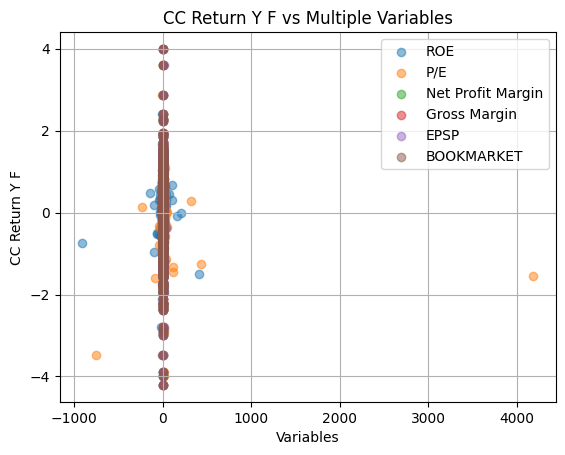

In [46]:
columns = ['ROE', 'P/E', 'Net Profit Margin','Gross Margin','EPSP','BOOKMARKET']
for i in columns:
    if i != 'cc_return_y_f':  # Evita graficar 'cc_return_y_f' contra sí mismo
        plt.scatter(data_regresion[i].values, data_regresion['cc_return_y_f'].values, alpha=0.5, label=i)

# Añadir título y etiquetas a los ejes
plt.title('CC Return Y F vs Multiple Variables')
plt.ylabel('CC Return Y F')
plt.xlabel('Variables')
plt.legend(loc='best')  # Coloca la leyenda en la mejor posición automática
plt.grid(True)  # Añade una cuadrícula para facilitar la lectura

Observamos la distribución de las variables independies vs la variable dependiente, no obstante, debido a sus tamaños,no es posible de apreciar con claridad la distribución de los datos.

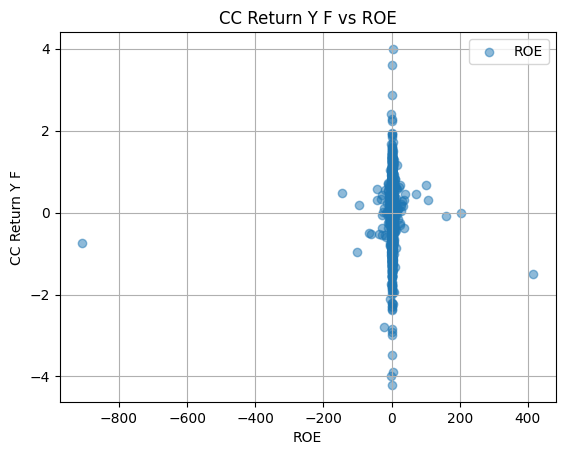

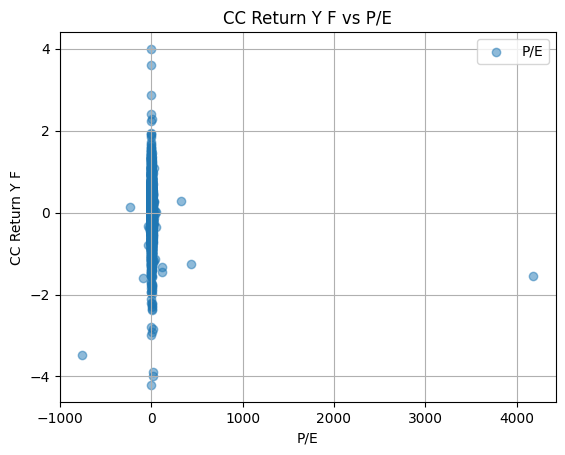

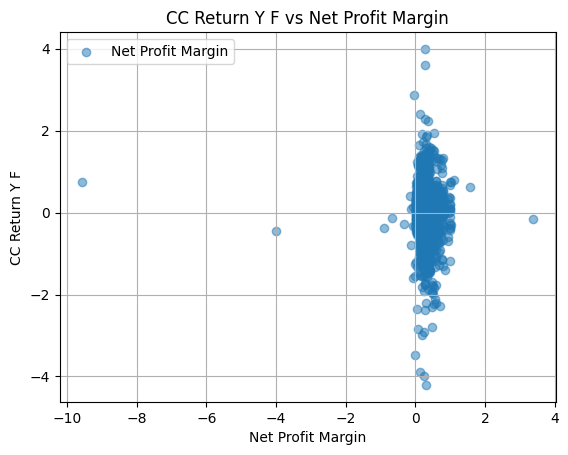

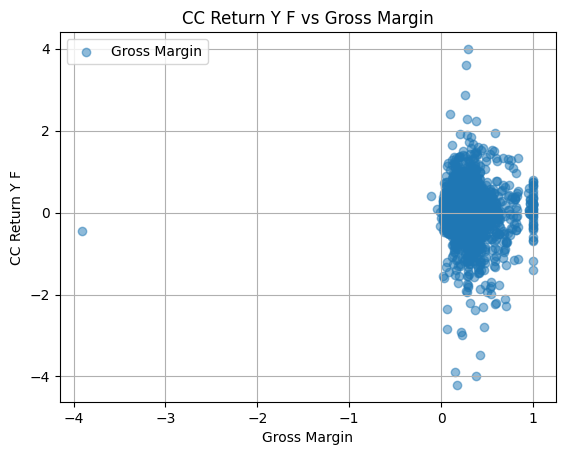

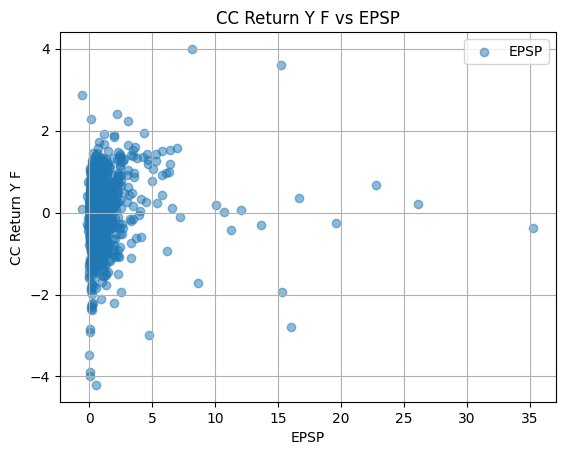

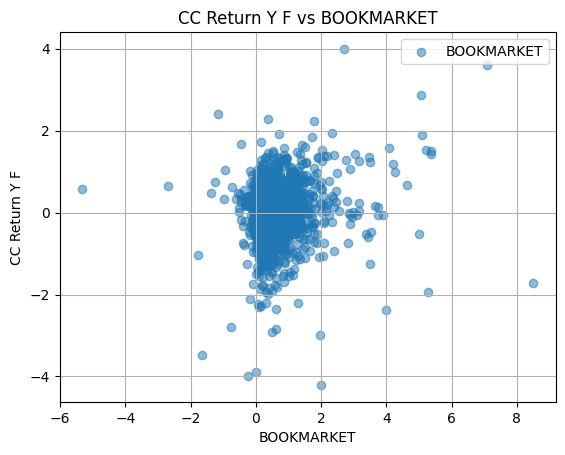

In [47]:
columns = ['ROE', 'P/E', 'Net Profit Margin','Gross Margin','EPSP','BOOKMARKET']
for i in columns:
    if i != 'cc_return_y_f':  # Evita graficar 'cc_return_y_f' contra sí mismo
        plt.scatter(data_regresion[i].values, data_regresion['cc_return_y_f'].values, alpha=0.5, label=i)

        # Añadir título y etiquetas a los ejes
        plt.title(f'CC Return Y F vs {i}')
        plt.ylabel('CC Return Y F')
        plt.xlabel(f'{i}')
        plt.legend(loc='best')  # Coloca la leyenda en la mejor posición automática
        plt.grid(True)  # Añade una cuadrícula para facilitar la lectura
        plt.show()

Visualización de los retornos compuestos futuros por cada variable independiente, lo que nos muestra este tipo de gráfica es la correlación y distribución de los datos, a su vez es muy notorio observar los datos atípicos. 

> **Advertencia**: MOSTRAMOS AQUELLAS VARIABLES O COLUMNAS QUE TENGAN NAN, Y SU PROPORCIÓN CON RESPECTO AL TOTAL DE LA DATASET EN PORCENTAJE

In [48]:
print(data_regresion.shape)
columns = ['ROE', 'P/E', 'Net Profit Margin', 'Gross Margin','BOOKMARKET','EPSP']
x = data_regresion[columns]
y = data_regresion['cc_return_y_f']
print('----Valores en X Nan----')
print(x.isna().sum())
print(171/3129*100,'%')

print('----Valores en Y Nan----')
print(y.isna().sum())
print(136/3129*100,'%')

(3129, 43)
----Valores en X Nan----
ROE                   0
P/E                  57
Net Profit Margin     0
Gross Margin          0
BOOKMARKET           57
EPSP                 57
dtype: int64
5.465004793863854 %
----Valores en Y Nan----
247
4.346436561201662 %


Visualizamos que en la dataset, las variables independietes tenemos un 5% de datos nulos, y en la variable de investigación 4% aproximadamente. 

In [49]:
 # Llenar los valores faltantes en 'x' con la mediana de cada columna
#x = x.apply(lambda col: col.fillna(col.median()), axis=0)

# Selecciona las columnas predictoras y la columna objetivo
columns = ['ROE', 'P/E', 'Net Profit Margin', 'Gross Margin','BOOKMARKET','EPSP']
X = data_regresion[columns]
y = data_regresion['cc_return_y_f']


# Añadir una constante al modelo (para el intercepto)
x = sm.add_constant(X)

# Ajustar el modelo de regresión
model = sm.OLS(y, x, missing="drop").fit()

# Mostrar el resumen del modelo
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          cc_return_y_f   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     9.659
Date:                Tue, 10 Sep 2024   Prob (F-statistic):           1.50e-10
Time:                        19:00:24   Log-Likelihood:                -2265.0
No. Observations:                2870   AIC:                             4544.
Df Residuals:                    2863   BIC:                             4586.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0285      0.02

Ejecutamos nuestro modelo con la dataset lo más puro posible para observar los rendimientos con los datos originales.

## INTERPRETACIÓN DEL MODELO DE REGRESIÓN ORIGINAL 

### COEFICIENTES 

In [92]:
model.params

const                0.028549
ROE                  0.000215
P/E                 -0.000275
Net Profit Margin   -0.078798
Gross Margin        -0.043621
BOOKMARKET           0.092178
EPSP                 0.015849
dtype: float64

1. Constante (intercepto):
    - Original: 0.0285.
    - La constante muestra un valor positivo, lo que representa el valor esperado de la variable dependiente cuando todas las variables independientes son iguales a 0.
2. ROE (Return on Equity):
    - Original: 0.00021.
    - La relación entre ROE y la variable dependiente es positiva, pero pequeña. Este coeficiente sugiere que un aumento en el ROE tiene un impacto limitado en la variable dependiente.
3. P/E (Price to Earnings Ratio):
    - Original: -0.00027.
    - El coeficiente negativo de P/E indica una relación inversa, lo que sugiere que un aumento en el P/E tiende a estar asociado con una disminución de la variable dependiente, aunque esta relación es muy débil.
4. Net Profit Margin:
    - Original: -0.0788.
    - La relación negativa con los retornos compuestos a futuro indica que a mayor margen de beneficio neto, los retornos tienden a disminuir. Aunque este coeficiente negativo es moderado, refleja una tendencia importante en la dinámica de la variable dependiente.
5. Gross Margin:
    - Original: -0.0436.
    - El coeficiente negativo sugiere que el margen bruto tiene una relación inversa con los retornos compuestos a futuro, aunque esta relación es leve. Esto podría indicar que otros factores externos estaban afectando esta variable en el modelo original.
6. BOOKMARKET
    - Original: 0.0921.
    - Un coeficiente positivo relativamente alto indica una fuerte relación entre el valor de BOOKMARKET y la variable dependiente. Los valores altos de BOOKMARKET parecen tener un impacto significativo en los retornos futuros.
7. EPSP (Earnings Per Share):
    - Original: 0.0158.
    - El coeficiente positivo muestra que a medida que aumentan las ganancias por acción, también lo hace la variable dependiente. Aunque el coeficiente es pequeño, refleja una tendencia positiva que puede tener implicaciones importantes a largo plazo.

### INTERPRETACIÓN DE R CUADRADA
Con este modelo original tendremos una precisión para describir el comportamiento de nuestra variable independiente con 2% de acertividad, ya que nuestra R cuadrada es de 0.02, en otras palabras, nuestro error descriptivo es del 98% para determinar o predecir los retornos anuales a futuro de una accion en el mercado estadounidense.

### INTERPRETACIÓN DE R CUADRADA AJUSTADA
La R cuadrada ajustada es de 0.018 que representa 1.8% de acertividad descritiva para predecir los retornos futuras de una acción, que a su vez representa que dentro de nuestro modelo existen coeficientes que introducen ruido al comportamiento de nuestro modelo, que estaban afectando un 0.2%.


### MULTICOLINEALIDAD

Es posible que exista un problema de multicolinealidad, y esto puede ser que nos esté ocasionando que nuestro modelo tenga poca descripción de nuestro modelo original. 
Es por ello, evaluar los coeficientes con la métrica VIF (Variance Inflation Factor).


In [50]:
x = x.dropna()

vif_data = pd.DataFrame()
vif_data["Variable"] = x.columns
vif_data["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]


for num,i in enumerate(vif_data['VIF']):
    if i>10:
        print('Multiconealidad beta',num,i)
    elif i>5:
        print('Correlación moderada que podría ser preocupante beta',num,i)
    elif 1<i and i<5:
        print(' Cierta correlación entre la variable independiente, no es la suficiente para ser preocupante beta',num,i)
    else:
        print('Escenario idela',num,i)
print(vif_data)

 Cierta correlación entre la variable independiente, no es la suficiente para ser preocupante beta 0 4.751857656177337
 Cierta correlación entre la variable independiente, no es la suficiente para ser preocupante beta 1 1.0051112836693956
 Cierta correlación entre la variable independiente, no es la suficiente para ser preocupante beta 2 1.0012480826817416
 Cierta correlación entre la variable independiente, no es la suficiente para ser preocupante beta 3 1.752928820700084
 Cierta correlación entre la variable independiente, no es la suficiente para ser preocupante beta 4 1.805444065325833
 Cierta correlación entre la variable independiente, no es la suficiente para ser preocupante beta 5 1.152132357531261
 Cierta correlación entre la variable independiente, no es la suficiente para ser preocupante beta 6 1.2032269377416185
            Variable       VIF
0              const  4.751858
1                ROE  1.005111
2                P/E  1.001248
3  Net Profit Margin  1.752929
4       G

Como se puede apreciar no hay multiconealidad en los coeficientes, en otras palabras, que no existen una una fuerte correlación entre variable independiente y dependientes ayudando al modelo en la estimaciones confiables de los coeficientes, mejor interpretabilidad y mayor etabilida del modelo.

### INTERPRETACIÓN DE LOS COEFICIENTES

Interpretacion de las betas optenidas de nuestro modelo de regresion lienal 
* t-Statistic
    - Estadística t o valor t: el número de desviaciones estándar alejados del valor cero con respecto al  coeficiente beta estimado.
     $$t= ((B_{n}-Hipo_{null}) / SE_{B_{n}})$$
* p-value
    - pvalue: la probabilidad de que me equivoque si rechazo la hipótesis nula.
     $$Pvalue=(1−ConfidenceLevel)$$
* 95% confidence interval 
    - Intervalo de confianza del 95%: los valores mínimos y máximos posibles que la beta puede tener un 95% de acertividad al considerar nuevas observaciones.
    $$ConfidenceInterval=(B_{mean}+-(1.96)*SE(B_{mean}))$$

### t-Statistic
 Cuando t es menor que 2, se interpreta como que no hay suficiente fuerza explicativa en la evidencia estadística para decir que el coeficiente es distinto de cero, si usamos el nivel de confianza del 95%. 

Hipótesis nula (H₀): El coeficiente es igual a 0 (no hay relación significativa entre nuestra variable independiente para poder describir como se comportan los redimientos compuestos a futuro).

Hipótesis alternativa (Hₐ): El coeficiente es mayor que 0 (existe una relación positiva entre la variable independiente para estimar la rentabilidad compuesta de futuros años futuro).

Dado que el valor absoluto del valor t no supera el umbral crítico de 2, esto indica que el efecto observado no es estadísticamente significativo. Por lo tanto, no podemos concluir que exista una relación positiva significativa entre la variable independiente para estimar la rentabilidad compuesta de futuros años futuro 

### p-value
El p-value mayor a 0.05 significa que no hay pruebas suficientes para demostrar que la variable tiene un efecto significativo, por lo que asumimos que su influencia en el modelo podría ser nula. 

In [51]:
# Obtener los residuos y predicciones
residuals = model.resid
y_pred = model.predict(x)

# Acceder a las betas, t-statistics y p-values
betas = model.params
t_statistics = model.tvalues
p_values = model.pvalues

# Evaluar la significancia de los coeficientes
significant_betas = model.pvalues < 0.05
print(significant_betas)
# Imprimir resultados de las betas significativas

for i, (beta, t_stat, p_value) in enumerate(zip(betas, t_statistics, p_values)):
    if p_value < 0.05:
        print('----------------------------------------')
        print(f"Beta {i} ({x.columns[i]}): {beta:.4f}, t-statistic: {t_stat:.4f}, p-value: {p_value:.4f} - Significativo (p < 0.05)")
        print('----------------------------------------')


const                False
ROE                  False
P/E                   True
Net Profit Margin    False
Gross Margin         False
BOOKMARKET            True
EPSP                  True
dtype: bool
----------------------------------------
Beta 2 (P/E): -0.0003, t-statistic: -2.2095, p-value: 0.0272 - Significativo (p < 0.05)
----------------------------------------
----------------------------------------
Beta 5 (BOOKMARKET): 0.0922, t-statistic: 5.2038, p-value: 0.0000 - Significativo (p < 0.05)
----------------------------------------
----------------------------------------
Beta 6 (EPSP): 0.0158, t-statistic: 2.0234, p-value: 0.0431 - Significativo (p < 0.05)
----------------------------------------


Es visible que las tres variables con mayor poder explicativo son P/E, BOOKMARKET y  EPSP, tiene un impacto positivo y significativo en nuestro modelo lineal, y estas tres variables cuentan con un poder explicativo del 95%, por lo que se traduce que estas tiene un 5% de error para describir la rentabilidad compuesta de futuros años. 


# 95% Invervalo de confianza


In [52]:
# Coeficiente estimado y error estándar
coef = model.params[1]
se_coef = model.bse[1]

# Intervalo de confianza del 95%
ci = model.conf_int(alpha=0.05)
print(f"95% Confidence Interval for the coefficient: {ci[1]}")

95% Confidence Interval for the coefficient: const                0.071160
ROE                  0.001184
P/E                 -0.000031
Net Profit Margin    0.017979
Gross Margin         0.095719
BOOKMARKET           0.126911
EPSP                 0.031208
Name: 1, dtype: float64


BOOOKMARKET, EPSP y Gross Margin, estas variables son las que representan un mayor intervalo de confianza para estimar la variable de invesitgación,  ya que se alejan más del cero. En otras palabras, podemos interpretar que estas variables tienen una correlación significativa para estimar nuestra variable dependiente, y no es probable que su efecto sea nulo.
1. BOOKMARKET → 0.126911
2. Gross Margin → 0.095719
3. EPSP → 0.031208

BOOKMARKET tiene un coeficiente positivo y significativo, podrías interpretar que un aumento en BOOKMARKET se asocia con un aumento en la variable dependiente.

Gross Margin indicaría que un aumento en el margen bruto se asocia con un aumento en la variable dependiente. Un coeficiente negativo sugeriría que un mayor margen bruto podría estar relacionado con una disminución en la variable dependiente, es algo no intuitivo, pero los datos son eso.

Un EPS alto sugiere que una empresa está generando buenos beneficios en relación con el número de acciones, lo que puede indicar una buena salud financiera. En caso posible de en que EPSP tenga un coeficiente positivo y significativo, este nos dice que un mayor EPS se asocia con un mayor valor o rendimiento de la variable dependiente. Un coeficiente negativo podría indicar lo contrario.


Por otro lado, P/E (Price to Earings ratio), esta variable tiene un pequeño impacto en el coeficiente, además el signo negativo representa que tiene un efecto inverso en la variable dependiente, es decir, si el P/E aumenta, se esperaría una disminución de la variable dependiente, aunque este efecto es muy pequeño debido a la magnitud del coeficiente.

Un P/E negativo y significativo puede indicar que las acciones con un P/E alto podrían no ser una buena inversión si el rendimiento de la acción disminuye con un P/E más alto. Esto puede alertar a los inversores sobre la posibilidad de sobrevaloración y la necesidad de reconsiderar la inversión.

<hr>

# DIAGNÓSTICO DE REGRESIÓN CON MATRICES ALGEBRAICAS


### Coeficientes de las betas
Nos da un array con las mejores coefieciente de cada feature o variable.

$$ Beta = (X^T * X)^-1 * X^T * y $$
- X → Matríz de variables independientes
- y → Variable dependiente
- X^T → La transpuesta de la matríz X

In [53]:

a=x.dropna()
b=y.dropna()

x, y = a.align(b, axis=0, join='inner')

x_array = x.to_numpy()
y_array = y.to_numpy()

betas = np.linalg.inv(x_array.T @ x_array) @ x_array.T @ y_array

print(f"Coeficientes beta:")
#vif_data.loc[i,'Variable']}
for i in range(vif_data.shape[0]):
    print(f'''{vif_data.loc[i,'Variable']} → {betas[i]}''')

Coeficientes beta:
const → 0.028549448749744945
ROE → 0.00021468041055622449
P/E → -0.0002746296612182065
Net Profit Margin → -0.07879783831106985
Gross Margin → -0.04362067259536266
BOOKMARKET → 0.09217824787070404
EPSP → 0.01584913716648328


Al parecer nuestros coeficientes estan bien calculados debidos a que son los mismos de la regresion lineal, y son las siete betas esperadas. 

## Error estándar 
El error estándar se refiere a la desviación estándar de la distribución teórica de una estadística muestral o poblacional
$$ SE = σ / \sqrt{N}$$
- σ → la desviación estándar de la población
- N → número de observaciones de la muestra

In [54]:
residuals = y_array - x_array @ betas

n, k = x_array.shape
sigma = residuals.T @ residuals / (n - k)

covariance_beta = sigma * np.linalg.inv(x_array.T @ x_array)

std_errors = np.sort(np.sqrt(np.diag(covariance_beta)))
print(f"Errores estándar de las betas")
#vif_data.loc[i,'Variable']}
for i in range(vif_data.shape[0]):
    print(f'''{vif_data.loc[i,'Variable']} → {std_errors[i]}''')

print('Promedio Std error: ',std_errors.mean())

Errores estándar de las betas
const → 0.00012429571314673092
ROE → 0.0004942533910157077
P/E → 0.00783292196409588
Net Profit Margin → 0.017713754300535775
Gross Margin → 0.02173110624301657
BOOKMARKET → 0.04935606506312028
EPSP → 0.07106295443692744
Promedio Std error:  0.024045050158836907


El promedio del error estándar de las betas es de  0.04614, que es muy bajo, esto puede indicar que el modelo es estremadamente complejo o que cuenta con multicolinealidad, también puede ser ambas, el segundo caso no puede ser posible porque la acabmos de evaluar y no existe multicolinealidad. 

Estas son las tres variables con mayor estimación y precisión     
1. Const 
2. ROE 
3. P/E 
Encambio estas dos son las menos precisas en estimación:
1. BOOKMARKET
2. EPSP 


## R Cuadrada
La r cuadrada evalua que tan preciso es nuestro modelo. 
$$ R^2=1 - (Σ(yi - ŷi)^2 / Σ(yi - ȳ)^2)$$

* yi → Es el valor observado de la variable dependiente
* ŷi → Es el valor predicho por el modelo
* ȳ→  Es la media de la variable dependiente
* Σ → Es la suma de los términos dentro del paréntesis

Otra forma
$$ R² = 1 - (SSres / SST)$$

* R² → Es el Coeficiente de Determinación (R cuadrado)
* SSr → Es es la suma de cuadrados de los residuos (error)
* SST → Es la suma de cuadrados totales (varianza total)


In [55]:
# Suma de cuadrados totales (SST)
sst = np.sum((y - np.mean(y))**2)

# Suma de cuadrados residuales (SSR) 
ssr = np.sum(residuals**2)

# R^2
r_squared = 1 - (ssr / sst)

print(f'R^2: {r_squared}')

R^2: 0.01984157062402847


La estimaciones del modelo se ajustan en un 1.9% a la predicción de retorno compuesto a futuro, algo esperado, ya que nuestro modelo original nos dio una r cuadrada del 2%.

## R Cuadrada Ajustada
La R cuadrada calcula la variación de la variable dependiente es explicado colectivamente por todas las variables independientes.
$$ R^2_{a}=1 - [(n-1)/(n-k-1)]*(1-R^2)$$

- R²a → R cuadrado ajustado o coeficiente de determinación ajustado
- R² → R cuadrado o coeficiente de determinación
- n → Número de observaciones de la muestra
- k → Número de variables independientes

In [56]:
r_squared_ajustado = 1 - (1 - r_squared) * (n - 1) / (n - k)
print(f'Adj R^2: {r_squared_ajustado}')


Adj R^2: 0.017787448871930733


Nuestra R cuadrada ajustada explica, que nuestras varaibles independiente, colectivamente tienen una aceritividad del 1.7% para predecir los retornos compuestos esperados para el futuro. 

## Matríz Hat
Indica el grado en que cada observación influye en los resultados de la regresión
$$ H = (X^T * X)^-1 * X^T * X $$

- H → Hat Matrix
- X → Matríz de variables independientes
- X^T → La transpuesta de la matríz X

In [57]:
from statsmodels.stats.outliers_influence import OLSInfluence
influence = OLSInfluence(model)
leverages = influence.hat_matrix_diag

# Paso 3: Identificar valores de leverage altos usando el criterio 2p/n
umbral_leverage = 2 * k / n
leverages_altos = np.where(leverages > umbral_leverage)[0]  # Índices de observaciones con leverage alto

# Mostrar los resultados
print("Valores de leverage:", leverages)
print(f"Umbral de leverage alto: {umbral_leverage}")
print("Índices de observaciones con leverage alto:", leverages_altos)
print(len(leverages_altos))

Valores de leverage: [0.00058361 0.00066882 0.0006796  ... 0.00041473 0.00044883 0.00074358]
Umbral de leverage alto: 0.004878048780487805
Índices de observaciones con leverage alto: [  27   45   46   47   48   49   50   51   52   53   54   55   56   86
  244  300  318  377  378  404  437  438  465  591  592  628  631  652
  732  760  764  791  897  898  902  903  904  962  964  965 1099 1132
 1146 1151 1152 1363 1401 1447 1552 1559 1640 1665 1668 1669 1672 1675
 1677 1678 1817 1873 1875 2022 2044 2059 2060 2061 2062 2063 2064 2065
 2066 2067 2068 2069 2070 2097 2180 2182 2196 2224 2280 2361 2393 2394
 2395 2396 2397 2411 2542 2577 2582 2583 2584 2617 2625 2626 2627 2628
 2629 2635 2706 2707 2708 2709 2710 2711 2712 2713 2714 2715 2716 2717
 2741 2742 2743 2744 2745 2746 2747 2748 2749 2750 2751 2752]
124


In [58]:
for i, leverage in enumerate(leverages):
    if leverage > umbral_leverage:
        print(f"Observación {i} tiene un leverage de {leverage:.4f}, que es superior al umbral de {umbral_leverage:.4f}.")
        print("Esto sugiere que esta observación tiene un gran impacto en el ajuste del modelo.")
    else:continue
        #print(f"Observación {i} tiene un leverage de {leverage:.4f}, que es inferior al umbral de {umbral_leverage:.4f}.")
        #print("Esto sugiere que esta observación tiene un impacto moderado en el modelo.")

Observación 27 tiene un leverage de 0.0056, que es superior al umbral de 0.0049.
Esto sugiere que esta observación tiene un gran impacto en el ajuste del modelo.
Observación 45 tiene un leverage de 0.1278, que es superior al umbral de 0.0049.
Esto sugiere que esta observación tiene un gran impacto en el ajuste del modelo.
Observación 46 tiene un leverage de 0.0959, que es superior al umbral de 0.0049.
Esto sugiere que esta observación tiene un gran impacto en el ajuste del modelo.
Observación 47 tiene un leverage de 0.0349, que es superior al umbral de 0.0049.
Esto sugiere que esta observación tiene un gran impacto en el ajuste del modelo.
Observación 48 tiene un leverage de 0.0713, que es superior al umbral de 0.0049.
Esto sugiere que esta observación tiene un gran impacto en el ajuste del modelo.
Observación 49 tiene un leverage de 0.0260, que es superior al umbral de 0.0049.
Esto sugiere que esta observación tiene un gran impacto en el ajuste del modelo.
Observación 50 tiene un leve

En el calculo del matríz hat nos arrojó 124 observaciones con un leverage mayor a 0.0049, eso indica que estas observaciones tienen una influencia significativa en la estimación de los coeficientes de mi modelo de regresión, que influyen críticamente a nuestro modelo por terner valores muy altos. Estos valores en géneral son los outliers que introducen ruido a nuestro modelo de regresión. 


## Posibles outliers usando residuos studentizados
Permiten la comparación de diferencias entre valores de destino observados y pronosticados en un modelo de regresión entre diferentes valores de predichos.

$$
\text{Residuo Estandarizado} = \frac{\text{Residuo}}{\text{Error Estándar del Residuo}}
$$
Donde:
$$
\text{Residuo} = y - \hat{y}
$$

El error estándar del residuo se calcula como:

$$
\text{Error Estándar del Residuo} = \sqrt{\frac{\sum (\text{Residuo}^2)}{n - k}}
$$

- y → son los valores observados.
- hat_y → son los valores predichos por el modelo.
- n → es el número total de observaciones.
- k → es el número de variables independientes (sin contar la constante).


In [59]:
# Calcular los residuales estándar
residuals = model.resid

# Suponiendo que `leverages` se ha calculado y tiene el mismo tamaño que los residuales
# Calcular la varianza residual ajustada
variance_residuals = np.sum(residuals**2) / (len(residuals) - len(model.params))

# Calcular los residuales studentizados
studentized_residuals = residuals / np.sqrt(variance_residuals * (1 - leverages))

# Identificar valores atípicos usando un umbral de 2
umbral = 2
outliers = np.where(np.abs(studentized_residuals) > umbral)[0]

# Mostrar resultados
print("Residuales studentizados:", studentized_residuals)
print(f"Umbral para considerar valores atípicos: ±{umbral}")
print("Índices de observaciones que podrían ser valores atípicos:", outliers)
print("Número de valores atípicos:", len(outliers))

Residuales studentizados: firm  qdate 
AAP   2002Q4    0.927960
      2003Q4    0.127091
      2004Q4    0.745013
      2005Q4   -0.359936
      2006Q4    0.122643
                  ...   
ZUMZ  2019Q1   -0.780347
      2020Q1    1.523192
      2021Q1   -0.286958
      2022Q1   -1.458162
      2023Q1   -0.562650
Length: 2870, dtype: float64
Umbral para considerar valores atípicos: ±2
Índices de observaciones que podrían ser valores atípicos: [  26   56   76   91  104  171  182  183  186  240  242  243  299  300
  323  376  401  403  404  418  441  447  470  478  479  481  483  625
  627  630  721  731  732  757  763  764  766  778  790  851  869  870
  903  933  935  938  945  946  950  961  964  965  966 1057 1070 1082
 1098 1108 1131 1132 1144 1145 1146 1151 1153 1221 1222 1226 1227 1228
 1273 1306 1309 1320 1362 1388 1400 1401 1446 1447 1448 1449 1513 1514
 1543 1544 1550 1559 1585 1588 1590 1592 1594 1619 1639 1671 1672 1677
 1678 1679 1681 1749 1750 1751 1755 1761 1767 1795 1796 1

In [60]:
atipico=[]
# Interpretación de los resultados
for i, residual in enumerate(studentized_residuals):
    if np.abs(residual) > umbral:
        print(f"Observación {i} tiene un residual studentizado de {residual:.4f}, indicando un posible valor atípico.")
        atipico.append(residual)
    else:
        #print(f"Observación {i} tiene un residual studentizado de {residual:.4f}, dentro del rango esperado.")
        continue

print(len(atipico))

Observación 26 tiene un residual studentizado de -2.4302, indicando un posible valor atípico.
Observación 56 tiene un residual studentizado de -2.0051, indicando un posible valor atípico.
Observación 76 tiene un residual studentizado de 2.3273, indicando un posible valor atípico.
Observación 91 tiene un residual studentizado de -3.4581, indicando un posible valor atípico.
Observación 104 tiene un residual studentizado de -3.7292, indicando un posible valor atípico.
Observación 171 tiene un residual studentizado de -2.0266, indicando un posible valor atípico.
Observación 182 tiene un residual studentizado de -2.0400, indicando un posible valor atípico.
Observación 183 tiene un residual studentizado de 2.1318, indicando un posible valor atípico.
Observación 186 tiene un residual studentizado de 2.7677, indicando un posible valor atípico.
Observación 240 tiene un residual studentizado de 2.1563, indicando un posible valor atípico.
Observación 242 tiene un residual studentizado de 2.0185, 

Al tener 155 valores atípicos sugiere que una parte considerable de las observaciones no sigue la tendencia general del modelo. Esto podría indicar problemas en el modelo, en los datos o la presencia de subgrupos en la población que no han sido correctamente modelados. Utilizamos el criterio de considerar outliers a aquellas observaciones cuyo residuo studentizado sea mayor que 2 o menor que -2 en valor absoluto. Esto se basa en la idea de que, bajo una distribución normal, cualquier punto con un residuo superior o inferior a 2 desviaciones estándar se aleja significativamente de lo esperado, sugiriendo que podría ser un valor atípico.

## Cook's distance 
Identificar observaciones influyentes que afectan de manera significativa la estimación de los coeficientes del modelo. Esta métrica combina la información sobre los residuos y el leverage para medir el impacto total de cada observación en el ajuste del modelo.
$$ D_{i} = (r^2_{i}/p*MSE)*(h_{i}/(1-h_{1}))^2 $$ 

* r_i → es el residuo stundentizados de la observación 
* h_i → es el leverage de la observación
* p → es el número de parámetros del modelo (incluido el intercepto)
* MSE → es el error cuadrático medio (mean squared error) del modelo

In [61]:
# Calcular la distancia de Cook
MSE = np.mean(model.resid**2) 
cooks_d2 = (studentized_residuals**2 / x_array.shape[1]*MSE) * (leverages / (1 - leverages)**2)

# Establecer el umbral para identificar valores atípicos
# umbral_cook = 4 / x_array.shape[0]
umbral_cook =1
outliers_cook2 = np.where( np.abs(cooks_d2) > umbral_cook)[0]

# Mostrar resultados
print("Distancias de Cook:", cooks_d2.values)
print(f"Umbral de Cook para considerar valores atípicos: {umbral_cook}")
print("Índices de observaciones que podrían ser valores atípicos:", outliers_cook2)


Distancias de Cook: [2.03982788e-05 4.38551869e-07 1.53135075e-05 ... 1.38567199e-06
 3.87246311e-05 9.55770315e-06]
Umbral de Cook para considerar valores atípicos: 1
Índices de observaciones que podrían ser valores atípicos: [ 591 1678]


In [62]:
cook_atipico = []
# Interpretación de los resultados
for i, cook in enumerate(cooks_d2):
    if np.abs(cook) > umbral_cook:
        print(f"Observación {i} tiene una distancia de Cook de {cook:.4f}, indicando un posible valor atípico.")
        cook_atipico.append(cook)
    else:
        #print(f"Observación {i} tiene una distancia de Cook de {cook:.4f}, dentro del rango aceptable.")
        continue

print(len(outliers_cook2))

Observación 591 tiene una distancia de Cook de 1.1499, indicando un posible valor atípico.
Observación 1678 tiene una distancia de Cook de 183.6234, indicando un posible valor atípico.
2


La distancia de Cook combina la magnitud de los residuos y el leverage para evaluar la influencia de una observación en el ajuste del modelo. Utilizamos un umbral de 1 como criterio, lo que significa que cualquier observación con una distancia de Cook superior a este valor se considera influyente. Esto indica que, si eliminamos dichas observaciones, los coeficientes del modelo podrían cambiar significativamente.

## Residuales studentizados y Cook, posibles observaciones influyentes.


In [63]:

influence_points2 = np.union1d(outliers, outliers_cook2)
print(f"Unión de Outliers y outliers_cook: {influence_points2}")
print('Outliers total',len(influence_points2))
print('Outlier',len(outliers))
print('Outlier cook',len(outliers_cook2))
# Extraer las distancias de Cook y residuales studentizados en los índices combinados
cook_distance_filtered2 = cooks_d2[influence_points2]
studentized_residuals_filtered = studentized_residuals[influence_points2]

# Crear DataFrames para concatenar
df_cook2 = pd.DataFrame(cook_distance_filtered2, columns=['cook_distance'])
df_residuals = pd.DataFrame(studentized_residuals_filtered, columns=['studentized_residuals'])
# Concatenar DataFrames a lo largo de las columnas
combined_df2 = pd.concat([df_cook2, df_residuals], axis=1)
print("\nDataFrame combinado:\n", combined_df2.values)
combined_df2.isna().sum()


Unión de Outliers y outliers_cook: [  26   56   76   91  104  171  182  183  186  240  242  243  299  300
  323  376  401  403  404  418  441  447  470  478  479  481  483  591
  625  627  630  721  731  732  757  763  764  766  778  790  851  869
  870  903  933  935  938  945  946  950  961  964  965  966 1057 1070
 1082 1098 1108 1131 1132 1144 1145 1146 1151 1153 1221 1222 1226 1227
 1228 1273 1306 1309 1320 1362 1388 1400 1401 1446 1447 1448 1449 1513
 1514 1543 1544 1550 1559 1585 1588 1590 1592 1594 1619 1639 1671 1672
 1677 1678 1679 1681 1749 1750 1751 1755 1761 1767 1795 1796 1813 1843
 1845 1939 1948 1951 1952 1968 1969 1972 2014 2016 2021 2043 2057 2062
 2066 2096 2111 2180 2195 2266 2279 2281 2368 2406 2410 2411 2414 2415
 2486 2515 2519 2541 2548 2583 2584 2613 2616 2629 2633 2634 2646 2674
 2800 2820]
Outliers total 156
Outlier 155
Outlier cook 2

DataFrame combinado:
 [[ 2.52292171e-04 -2.43020363e+00]
 [ 6.72774287e-02 -2.00512196e+00]
 [ 1.18580026e-04  2.32734496e+00

cook_distance            0
studentized_residuals    0
dtype: int64

Combinamos los outliers identificados tanto en los residuos studentizados como en la distancia de Cook. Esta integración se realizó porque ambos indicadores sugieren que estas observaciones son posibles fuentes de sesgo que podrían distorsionar las estimaciones de nuestro modelo y afectar negativamente su precisión. Identificar estos puntos influyentes es fundamental para garantizar que el análisis sea más robusto y que los resultados obtenidos sean lo más precisos y confiables posible.


## Lista de las observaciones influyentes y decida si eliminarlas o mantener algunas de ellas


In [64]:
print('Datos totales: ', len(x))
print('Outlier totales: ', len(influence_points2))
print('Porcentaje de los datos que representan los outliers',  len(influence_points2)*100/len(x),'%')
print(len(x),len(influence_points2),len(x)-len(influence_points2))

x_cleaned2 = x.drop(x.index[influence_points2])
x_cleaned2

Datos totales:  2870
Outlier totales:  156
Porcentaje de los datos que representan los outliers 5.435540069686411 %
2870 156 2714


const       ROE       P/E  Net Profit Margin  Gross Margin  \
firm qdate                                                                
AAP  2002Q4    1.0  2.799213  1.331296           0.398745      0.440403   
     2003Q4    1.0  2.283141  2.084618           0.412520      0.459261   
     2004Q4    1.0  2.232545  1.991679           0.427712      0.465049   
     2005Q4    1.0  2.001271  2.554113           0.431588      0.472331   
     2006Q4    1.0  1.968399  1.844451           0.439539      0.476803   
...            ...       ...       ...                ...           ...   
ZUMZ 2019Q1    1.0  0.799246  1.984659           0.327056      0.343276   
     2020Q1    1.0  0.745864  1.285718           0.336164      0.354465   
     2021Q1    1.0  0.595922  3.337609           0.332411      0.353318   
     2022Q1    1.0  0.893002  1.820215           0.353257      0.385795   
     2023Q1    1.0  0.772380  1.142321           0.328275      0.338778   

             BOOKMARKET      EPSP  
firm qdate                         
AAP  2002Q4    0.268343  0.751148  
     2003Q4    0.210107  0.479704  
     2004Q4    0.224895  0.502089  
     2005Q4    0.195638  0.391525  
     2006Q4    0.275435  0.542167  
...                 ...       ...  
ZUMZ 2019Q1    0.630425  0.503865  
     2020Q1    1.042784  0.777776  
     2021Q1    0.502777  0.299616  
     2022Q1    0.615212  0.549386  
     2023Q1    1.133394  0.875411  

[2714 rows x 7 columns]

Al revisar la lista, observamos que los outliers representan el 5% de nuestro conjunto de datos, lo que equivale a eliminar 156 observaciones. Esto reduciría nuestro dataset total a 2,714 observaciones, lo que podría tener un impacto significativo en la calidad del modelo y en las conclusiones del análisis. Sin embargo,  es importante evaluar las consecuencias de esta eliminación, es importante validar el modelo después de la eliminación para verificar que la precisión y la robustez hayan mejorado.


> **Advertencia**: OBSERVACIONES GENERALES DE NUESTRO MODELO CON LOS OUTLIERS ELIMINADOS CONTRA LA REGRESIÓN LINEAL ORIGINAL

In [65]:
X, Y = x_cleaned2.align(y, axis=0, join='inner')
model_sin_outliers = sm.OLS(Y, X, missing="drop").fit()
model_sin_outliers.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          cc_return_y_f   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     10.71
Date:                Tue, 10 Sep 2024   Prob (F-statistic):           8.50e-12
Time:                        19:00:25   Log-Likelihood:                -1163.5
No. Observations:                2714   AIC:                             2341.
Df Residuals:                    2707   BIC:                             2382.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0696      0.018      3.956      0.000       0.035       0.104
ROE                   0.0008      0.001      0.828      0.408      -0.001       0.003
P/E                   0.0006      0.001      0.651      0.515      -0.001       0.002
Net Profit Margin    -0.0701      0.035     -2.028      0.043      -0.138      -0.002
Gross Margin         -0.0687      0.054     -1.273      0.203      -0.175       0.037
BOOKMARKET            0.0666      0.015      4.522      0.000       0.038       0.096
EPSP                  0.0257      0.007      3.629      0.000       0.012       0.040
==============================================================================
Omnibus:                       31.198   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.998
Skew:                          -0.212   Prob(JB):                     2.51e-08
Kurtosis:                       3.360   Cond. No.                         76.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Al eliminar los datos de nuestra dataset, obtenemos una mejora en nuestro modelo de regresión lineal, no obstante, esta mejora es mímina. 

Un análisis a grosso modo: 

Nuestra r cuadrada era de 2%, ahora es de 2.3%, y la r cuadrada ajustada era del 1.8% y ahora es de 2.1%. Esto nos lleva hacer otro análisis para viasualizar si al eliminar estos outlier representan una perdida significativa para nuestro modelo, para ello vamos utilizar la winsorización.

In [66]:

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]


for num,i in enumerate(vif_data['VIF']):
    if i>10:
        print('Multiconealidad beta',num,i)
    elif i>5:
        print('Correlación moderada que podría ser preocupante beta',num,i)
    elif 1<i and i<5:
        print(' Cierta correlación entre la variable independiente, no es la suficiente para ser preocupante beta',num,i)
    else:
        print('Escenario idela',num,i)
print(vif_data)

Correlación moderada que podría ser preocupante beta 0 6.065392720522346
 Cierta correlación entre la variable independiente, no es la suficiente para ser preocupante beta 1 1.018957031061718
 Cierta correlación entre la variable independiente, no es la suficiente para ser preocupante beta 2 1.0233730324778298
 Cierta correlación entre la variable independiente, no es la suficiente para ser preocupante beta 3 1.5116650506124147
 Cierta correlación entre la variable independiente, no es la suficiente para ser preocupante beta 4 1.5832184884375897
 Cierta correlación entre la variable independiente, no es la suficiente para ser preocupante beta 5 1.190671589800656
 Cierta correlación entre la variable independiente, no es la suficiente para ser preocupante beta 6 1.2571856875430514
            Variable       VIF
0              const  6.065393
1                ROE  1.018957
2                P/E  1.023373
3  Net Profit Margin  1.511665
4       Gross Margin  1.583218
5         BOOKMARKET  1

## Winsorización
La winsorización es una técnica de tratamiento de datos que se utiliza para reducir el impacto de los valores atípicos (outliers) en un análisis estadístico. En lugar de eliminar los outliers, la winsorización los reemplaza por valores más cercanos dentro de un rango aceptable. Esto se hace truncando los valores extremos a los percentiles más altos o más bajos del conjunto de datos.

Los valores en 1% más bajo y más alto suelen ser considerados extremos, por lo que los ajustaremos para poder estabilizar el modelo sin eliminar datos importantes.



In [89]:
from scipy.stats.mstats import winsorize
ratios = ['ROE', 'P/E', 'Net Profit Margin', 'Gross Margin','BOOKMARKET','EPSP']
x_winsorized2 = x.copy()
for ratio in ratios:
    x_winsorized2[ratio] = winsorize(x[ratio], limits=[0.01, 0.01])
X2, Y2 = x_winsorized2.align(y, axis=0, join='inner')


Winsorización del 1% ajusta los valores extremos de nuestro conjunto de datos al reemplazar los valores que están en el 1% inferior y el 1% superior con los valores de los percentiles 1 y 99, respectivamente. En otras palabras, esta técnica asegura que solo el 2% de los datos extremos (1% en cada extremo) se recorten para que no afecten en exceso el análisis.

In [68]:
model_adjusted = sm.OLS(Y2, X2, missing="drop").fit()
model_adjusted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          cc_return_y_f   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     16.60
Date:                Tue, 10 Sep 2024   Prob (F-statistic):           6.59e-19
Time:                        19:00:25   Log-Likelihood:                -2244.6
No. Observations:                2870   AIC:                             4503.
Df Residuals:                    2863   BIC:                             4545.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0918      0.030      3.028      0.002       0.032       0.151
ROE                   0.0007      0.005      0.146      0.884      -0.009       0.010
P/E                  -0.0109      0.004     -2.870      0.004      -0.018      -0.003
Net Profit Margin    -0.9363      0.257     -3.650      0.000      -1.439      -0.433
Gross Margin          0.6050      0.230      2.634      0.008       0.155       1.055
BOOKMARKET            0.0391      0.025      1.584      0.113      -0.009       0.088
EPSP                  0.0819      0.018      4.541      0.000       0.047       0.117
==============================================================================
Omnibus:                      887.694   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9176.960
Skew:                          -1.161   Prob(JB):                         0.00
Kurtosis:                      11.447   Cond. No.                         162.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Nuestro modelo mejor drásticamente comparado al modelo anterior en la cual eliminamos los outliers, por lo que, este último será nuestro modelo final para analizar. Al final, conservamos los 2870 datos totales de nuestra dataset, para hacerles imputación de los outliers de esta misma. 
 

<hr>

# Modelo optimizado de regresión lineal

### MODELO WINSORIZADO VS MODELO ORIGINAL

Original

In [69]:
# Modelo original
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          cc_return_y_f   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     9.659
Date:                Tue, 10 Sep 2024   Prob (F-statistic):           1.50e-10
Time:                        19:00:25   Log-Likelihood:                -2265.0
No. Observations:                2870   AIC:                             4544.
Df Residuals:                    2863   BIC:                             4586.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0285      0.022      1.314      0.189      -0.014       0.071
ROE                   0.0002      0.000      0.434      0.664      -0.001       0.001
P/E                  -0.0003      0.000     -2.209      0.027      -0.001   -3.09e-05
Net Profit Margin    -0.0788      0.049     -1.597      0.110      -0.176       0.018
Gross Margin         -0.0436      0.071     -0.614      0.539      -0.183       0.096
BOOKMARKET            0.0922      0.018      5.204      0.000       0.057       0.127
EPSP                  0.0158      0.008      2.023      0.043       0.000       0.031
==============================================================================
Omnibus:                      889.626   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9532.836
Skew:                          -1.153   Prob(JB):                         0.00
Kurtosis:                      11.625   Cond. No.                         647.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Winsorizado

In [70]:
# Modelo winsorizado
model_adjusted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          cc_return_y_f   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     16.60
Date:                Tue, 10 Sep 2024   Prob (F-statistic):           6.59e-19
Time:                        19:00:25   Log-Likelihood:                -2244.6
No. Observations:                2870   AIC:                             4503.
Df Residuals:                    2863   BIC:                             4545.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0918      0.030      3.028      0.002       0.032       0.151
ROE                   0.0007      0.005      0.146      0.884      -0.009       0.010
P/E                  -0.0109      0.004     -2.870      0.004      -0.018      -0.003
Net Profit Margin    -0.9363      0.257     -3.650      0.000      -1.439      -0.433
Gross Margin          0.6050      0.230      2.634      0.008       0.155       1.055
BOOKMARKET            0.0391      0.025      1.584      0.113      -0.009       0.088
EPSP                  0.0819      0.018      4.541      0.000       0.047       0.117
==============================================================================
Omnibus:                      887.694   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9176.960
Skew:                          -1.161   Prob(JB):                         0.00
Kurtosis:                      11.447   Cond. No.                         162.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## R CUADRADA MODELO WINSORIZADO VS ORIGINAL

La R cuadrada en modelo original es del 2%, y tras implementar la winsorización aumentó a 3.4%. Esto indica que nuestro modelo es un 1.4% más efectivo para describir el comportamiento de los retornos compuestos a futuro.

## R CUADRADA AJUSTADA MODELO WINSORIZADO VS ORIGINAL

La R cuadrada ajustada en modelo original es de 1.8%, mientras que en el modelo con winsorización aumentó a 3.2%. Esto significa que nuestro modelo es un 1.4% más eficaz en describir el comportamiento de los retornos compuestos a futuro, considerando el conjunto de variables independientes.

## COEFICIENTES MODELO WINSORIZADO VS ORIGINAL

In [71]:
coeficientes2 = model_adjusted.params
coeficientes1 = model.params
print(f'''
Coeficientes
BETAS -------------- WINSORIZADO ------ ORIGINAL 
''')
for i in range(len(coeficientes1)):
    print(f'''{vif_data.loc[i,'Variable']} -------------- {coeficientes2[i]} ------ {coeficientes1[i]}  ''')


Coeficientes
BETAS -------------- WINSORIZADO ------ ORIGINAL 

const -------------- 0.09184321983489689 ------ 0.028549448749744674  
ROE -------------- 0.0006894925379228236 ------ 0.0002146804105562104  
P/E -------------- -0.010875701310979799 ------ -0.00027462966121821015  
Net Profit Margin -------------- -0.936253536268253 ------ -0.07879783831106954  
Gross Margin -------------- 0.6050123629889362 ------ -0.04362067259536238  
BOOKMARKET -------------- 0.03914757759165833 ------ 0.09217824787070399  
EPSP -------------- 0.0818639126160939 ------ 0.0158491371664834  


1. Constante (intercepto):
    - Winsorizado: 0.0918, Original: 0.0285
    - La constante ha aumentado considerablemente tras la winsorización, lo que indica que el ajuste del modelo ha cambiado

2. ROE (Return on Equity):
    - Winsorizado: 0.00069, Original: 0.00021.
    - La relación entre ROE y la variable dependiente se vuelve más evidente, permitiendo que el coeficiente sea mayor.

3. P/E (Price to Earnings Ratio):
    - Winsorizado: -0.0108, Original: -0.00027
    - El coeficiente de P/E se volvió mucho más negativo, a su vez nos sugiere una relación inversa más fuerte con respecto a la variable dependiente después de haber aplicado la winsorización.

4. Net Profit Margin:
    - Winsorizado: -0.9362, Original: -0.0788
    - El cambio más drástico se observa aquí. La relación negativa con los retornos compuestos a futuro es mucho más fuerte tras la winsorización.  Los valores atípicos estuvieran sesgando la estimación original del coeficiente, y al eliminarlos, muestra con mayor claridad la relación inversa Net Profit Margin para estimar los retorno compuestos a futuro.

5. Gross Margin:
    - Winsorizado: 0.6050, Original: -0.0436
    - En el modelo original, el Gross Margin tenía un coeficiente ligeramente negativo, pero tras la winsorización, cambió a positivo y significativo. Esto snos dice que los valores atípicos estaban ocultando una relación positiva importante entre el margen bruto y los retornos compuestos a futuro. 

6. BOOKMARKET:
    - Winsorizado: 0.0391, Original: 0.0921
    - El coeficiente de BOOKMARKET se redujo casi a la mitad. Esto significa que los valores atípicos estaban inflando su relación con la variable dependiente, y después de la winsorización, su efecto es más moderado.

7. EPSP (Earnings Per Share):
    - Winsorizado: 0.0818, Original: 0.0158
    - El coeficiente de EPSP también ha aumentado significativamente tras la winsorización, lo que indica que el impacto de los valores extremos en esta variable estaba afectando su relación con los retornos. Al reducir el valor de los valores extremos, se muestra una relación más fuerte y positiva.


## MULTICOLINEALIDAD MODELO WINSORIZADO 

In [72]:

XW=X2.copy()
vif_data2 = pd.DataFrame()
vif_data2["Variable"] = XW.columns
vif_data2["VIF"] = [variance_inflation_factor(XW.values, i) for i in range(XW.shape[1])]


for num,i in enumerate(vif_data2['VIF']):
    if i>10:
        print('Multiconealidad beta',num,i)
    elif i>5:
        print('Correlación moderada que podría ser preocupante beta',num,i)
    elif 1<i and i<5:
        print(' Cierta correlación entre la variable independiente, no es la suficiente para ser preocupante beta',num,i)
    else:
        print('Escenario ideal',num,i)
print(vif_data2)

Correlación moderada que podría ser preocupante beta 0 9.416582012967625
 Cierta correlación entre la variable independiente, no es la suficiente para ser preocupante beta 1 1.103948646093452
 Cierta correlación entre la variable independiente, no es la suficiente para ser preocupante beta 2 1.3563752030149694
Multiconealidad beta 3 15.46016916325332
Multiconealidad beta 4 15.357992214707801
 Cierta correlación entre la variable independiente, no es la suficiente para ser preocupante beta 5 1.6004895767079548
 Cierta correlación entre la variable independiente, no es la suficiente para ser preocupante beta 6 1.8451354097604313
            Variable        VIF
0              const   9.416582
1                ROE   1.103949
2                P/E   1.356375
3  Net Profit Margin  15.460169
4       Gross Margin  15.357992
5         BOOKMARKET   1.600490
6               EPSP   1.845135


El modelo explica una mayor proporción de la variabilidad de la variable dependiente, lo que parece positivo en términos de ajuste. Sin embargo, Net Profit Margin y Gross Margin cuentan con multiconealidad al utilizar la técnica de winsorización.

Esto genera tres cosas: 

1. Coeficientes poco confiables
2. Sobreajuste
3. Complicación para interpretar las variables dependientes

Posibles soluciones <br>
Aplicar técnicas como la eliminación de variables altamente correlacionadas, combinación de variables, o la aplicación de regularización (Ridge o Lasso).

Entonces, la mejora de mi R cuadrada es pequeña, podría ser más beneficioso reducir la multicolinealidad, que sobre un ligero incremento en R cuadrada.



## P-VALUE Y T-STATISTIC  WINSORIZADO VS ORIGINAL

In [73]:
# Obtener los residuos y predicciones
residuals = model_adjusted.resid
y_pred =model_adjusted.predict(x)

# Acceder a las betas, t-statistics y p-values
betas = model_adjusted.params
t_statistics = model_adjusted.tvalues
p_values = model_adjusted.pvalues

# Evaluar la significancia de los coeficientes
significant_betas = model_adjusted.pvalues < 0.05
print(significant_betas)
# Imprimir resultados de las betas significativas

for i, (beta, t_stat, p_value) in enumerate(zip(betas, t_statistics, p_values)):
    if p_value < 0.05:
        print('----------------------------------------')
        print(f"Beta {i} ({x.columns[i]}): {beta:.4f}, t-statistic: {t_stat:.4f}, p-value: {p_value:.4f} - Significativo (p < 0.05)")
        print('----------------------------------------')

const                 True
ROE                  False
P/E                   True
Net Profit Margin     True
Gross Margin          True
BOOKMARKET           False
EPSP                  True
dtype: bool
----------------------------------------
Beta 0 (const): 0.0918, t-statistic: 3.0275, p-value: 0.0025 - Significativo (p < 0.05)
----------------------------------------
----------------------------------------
Beta 2 (P/E): -0.0109, t-statistic: -2.8703, p-value: 0.0041 - Significativo (p < 0.05)
----------------------------------------
----------------------------------------
Beta 3 (Net Profit Margin): -0.9363, t-statistic: -3.6499, p-value: 0.0003 - Significativo (p < 0.05)
----------------------------------------
----------------------------------------
Beta 4 (Gross Margin): 0.6050, t-statistic: 2.6341, p-value: 0.0085 - Significativo (p < 0.05)
----------------------------------------
----------------------------------------
Beta 6 (EPSP): 0.0819, t-statistic: 4.5410, p-value: 0.00

1. Const 
    * Estadístico t: 3.0275
    * p-valor: 0.0025 (Significativo)
    - La constante es significativa, lo que significa que el modelo ajustado tiene una intersección en el eje Y cuando todas las variables independientes son cero. Este valor sugiere que, en ausencia de cambios en las variables independientes, los retornos compuestos futuros tienen un valor positivo.

2. P/E (Price to Earnings Ratio)
    * Estadístico t: -2.8703
    * p-valor: 0.0041 (Significativo)
    - El coeficiente es negativo y significativo, lo que indica que un mayor ratio P/E está asociado con una disminución en los retornos compuestos futuros. En este caso, el valor negativo implica que las empresas con ratios P/E más altos tienden a tener retornos menores. El p-valor menor a 0.05 sugiere que esta relación es estadísticamente significativa.

3. Net Profit Margin 
    * Estadístico t: -3.6499
    * p-valor: 0.0003 (Significativo)
    - El coeficiente negativo y significativo indica que un mayor margen de beneficio neto está asociado con menores retornos compuestos futuros. Esto puede parecer contraintuitivo, pero podría deberse a la relación específica entre la rentabilidad neta y los retornos de mercado en el contexto de tu dataset. La magnitud del coeficiente (-0.9363) sugiere que esta variable tiene un gran impacto en los retornos compuestos a futuro.

4. Gross Margin 
    * Estadístico t: 2.6341
    * p-valor: 0.0085 (Significativo)
    - Un mayor margen bruto está asociado con un aumento en los retornos compuestos futuros. El coeficiente positivo y significativo (0.6050) sugiere que las empresas con márgenes brutos más altos tienden a generar mayores retornos en el futuro. El p-valor de 0.0085 confirma que esta relación es estadísticamente significativa.

5.  EPSP (Earnings Per Share)
    * Estadístico t: 4.5410
    * p-valor: 0.0000 (Significativo)
    - El coeficiente positivo y altamente significativo sugiere que un mayor EPSP está asociado con mayores retornos compuestos futuros. Este resultado muestra que los ingresos por acción (EPSP) tienen un fuerte impacto positivo en los retornos. El hecho de que el p-valor sea tan bajo (0.0000) indica que esta relación es altamente significativa.



## ERROR ESTÁNDAR

In [74]:
# Obtener errores estándar
errores_estandar = model_adjusted.bse
print("Errores estándar de los coeficientes:")
print(errores_estandar)

Errores estándar de los coeficientes:
const                0.030336
ROE                  0.004710
P/E                  0.003789
Net Profit Margin    0.256515
Gross Margin         0.229687
BOOKMARKET           0.024707
EPSP                 0.018028
dtype: float64


Los  dos coeficientes con mayor error estánsar para la precisión de estimación de retornos compuestos futuros es Net Profit Margin y Gross Margin.

## CONCLUSIÓN DE LOS RESULTADOS 


Con el nuevo modelo, hemos observado mejoras en términos de R cuadrada, lo que indica un mayor poder explicativo de los coeficientes y una mayor confianza en la capacidad del modelo para predecir los retornos compuestos en los años futuros. Esto sugiere que el modelo es más efectivo en capturar la relación entre las variables predictoras y la variable dependiente.

Sin embargo, al aplicar winsorización a los datos, el modelo reveló una alta multicolinealidad entre los coeficientes del P/E (Price to Earnings Ratio) y el Net Profit Margin, con un valor de correlación superior al 95%. Esta alta multicolinealidad es problemática, ya que puede llevar a inestabilidad en los coeficientes del modelo, significancias erróneas y errores estándar inflacionados, comprometiendo la precisión y la interpretabilidad del modelo.

En contraste, el modelo que solo eliminó los outliers mostró una mejora modesta del 0.3% en la explicación de los retornos compuestos futuros, lo cual es una mejora mínima pero significativa. Este modelo no presentó problemas de multicolinealidad entre las variables predictoras e independientes.

Por lo tanto, el mejor enfoque parece ser eliminar los outliers, ya que este método mejora la precisión del modelo sin introducir multicolinealidad significativa entre las variables, manteniendo la estabilidad de los coeficientes y la confiabilidad del análisis.


## ÁREAS DE OPORTUNIDAD


Investigar y seleccionar ratios financieros que presenten una correlación positiva más fuerte y mayor poder explicativo con los retornos compuestos. Evaluar estos ratios adicionales puede ofrecer una mejor comprensión de los factores que impulsan el comportamiento de los retornos compuestos, mejorando la capacidad predictiva del modelo.
A su vez ajusta los parámetros de winsorización para evitar el sobreajuste de los datos. Es crucial encontrar un equilibrio que minimice el impacto de los outliers sin alterar en exceso la distribución de los datos, preservando así la validez y generalización del modelo.

Por último,  adopta técnicas de modelado más sofisticadas para manejar la complejidad de los datos. Modelos como la regresión Ridge, regresión Lasso, bosques aleatorios (Random Forest), y máquinas de soporte vectorial (SVM). 
